<a href="https://colab.research.google.com/github/skyshine460/GHG_Direct_Emissions/blob/main/submit_ghg51.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 初期設定

In [6]:
pip install pygeohash

In [7]:
pip install catboost

In [8]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import joblib
import math

import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

import gc
gc.collect()

import os

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# データの読み込み

In [10]:
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/train.csv')

# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/test.csv')

In [11]:
# 各カラムのデータ型と欠損値（nan）を表示
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    print(df.shape)
    return info_df

def normal_distribution_fit(df, col):

    # 正規分布のフィッティング
    from scipy.stats import norm
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # カテゴリデータかどうかを判定
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        # カテゴリデータの場合
        sns.countplot(x=df[col], ax=ax[0])
        ax[0].set_title('Bar Plot of Categorical Data')
    else:
        # 数値データの場合
        sns.histplot(df[col], kde=True, stat='density', ax=ax[0])
        # 正規分布のフィット
        sns.histplot(df[col], stat='density', ax=ax[0], bins=30)
        x = np.linspace(df[col].min(), df[col].max(), 100)
        ax[0].plot(x, norm.pdf(x, df[col].mean(), df[col].std()), color='red')
        ax[0].set_title('Histogram with Normal Distribution Fit')

        # Q-Qプロット
        stats.probplot(df[col], plot=ax[1])
        ax[1].set_title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

    # 数値データの場合のみ歪度と尖度を計算
    if df[col].dtype != 'object' and df[col].dtype.name != 'category':
        print(f"Skewness: {df[col].skew()}")
        print(f"Kurtosis: {df[col].kurt()}")

    # 欠損値の確認
    print(f"isnull: {df[col].isnull().sum()}")

In [12]:
information_df(train_df)

(4655, 22)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,4655,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
FacilityName,object,0,4531,"[VISCOFAN USA INC, CORNWELL STATION - DOMINION..."
Latitude,float64,102,4492,"[40.141389, 38.475305, 39.29982, 35.490363, 41..."
Longitude,float64,102,4486,"[-87.581111, -81.278957, -80.85717, -119.04295..."
LocationAddress,object,179,4435,"[915 N MICHIGAN AVE, 200 RIVER HAVEN ROAD, 304..."
City,object,0,2588,"[DANVILLE, CLENDENIN, GREENWOOD, BAKERSFIELD, ..."
State,object,0,54,"[IL, WV, CA, OH, OK, NM, TN, LA, TX, IN, NC, M..."
ZIP,object,0,3758,"[61832, 25045-9304, 26415, 93308, 441031047, 7..."
County,object,70,1165,"[VERMILION, KANAWHA, RITCHIE, KERN, CUYAHOGA, ..."
FIPScode,float64,73,1646,"[17183.0, 54039.0, 54085.0, 6029.0, 39035.0, 4..."


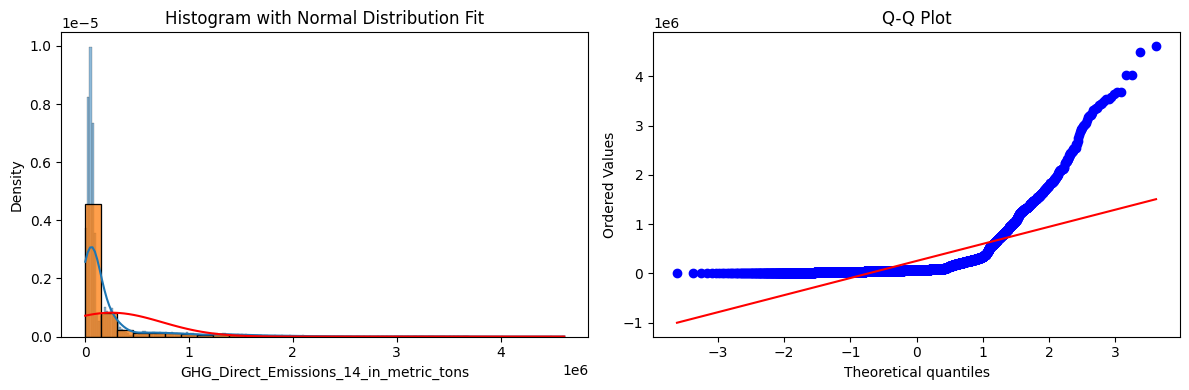

Skewness: 3.6649052199295338
Kurtosis: 16.560320863687245
isnull: 0


In [13]:
normal_distribution_fit(train_df, 'GHG_Direct_Emissions_14_in_metric_tons')

評価指標はRMSLEであり、ヒストグラムも右に裾が長いグラフなので、対数変換を行う。

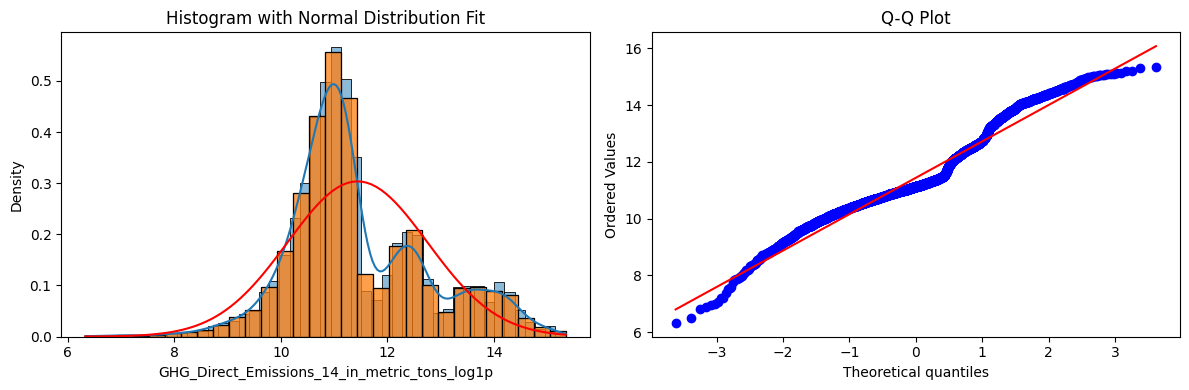

In [14]:
train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'] = np.log1p(train_df['GHG_Direct_Emissions_14_in_metric_tons'])
normal_distribution_fit(train_df, 'GHG_Direct_Emissions_14_in_metric_tons_log1p')

In [15]:
information_df(test_df)

Skewness: 0.545884275422693
Kurtosis: 0.3515490436747801
isnull: 0
(2508, 21)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,2508,"[4655, 4656, 4657, 4658, 4659, 4660, 4661, 466..."
FacilityName,object,0,2462,"[ROGER AOTSCHEGAROW, EPNG STATION 6543 LORDSBU..."
Latitude,float64,56,2437,"[38.03304, 32.31603, 41.2515, 44.95966, 32.818..."
Longitude,float64,56,2435,"[-97.97317, -108.6068, -78.74244, -93.19341, -..."
LocationAddress,object,113,2386,"[1910 SOUTH BROADACRES ROAD, nan, 3831 ROUTE 2..."
City,object,0,1647,"[HUTCHINSON, LORDSBURG, BROCKPORT, SAINT PAUL,..."
State,object,0,54,"[KS, NM, PA, MN, CA, MS, MT, AZ, IN, NY, IL, F..."
ZIP,object,0,2152,"[67501, 88045, 15823, 551141895, 92123, 38606,..."
County,object,45,865,"[RENO, HIDALGO, JEFFERSON, RAMSEY, SAN DIEGO, ..."
FIPScode,float64,45,1162,"[20155.0, 35023.0, 42065.0, 27123.0, 6073.0, 2..."


In [16]:
def merge_train_test(df_train, df_test):
    if "is_train" not in df_test.columns.tolist():
        df_train["is_train"] = 100
        df_test["is_train"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["is_train"] != -100]
    df_test = df[df["is_train"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(train_df, test_df)

In [17]:
# object型をカテゴリ型に変換する
for col in df.columns:
    if df[col].dtype == "object":  # object型の列を探す
        df[col] = df[col].astype("category")  # カテゴリ型に変換

# GHGの特徴量

In [18]:
df['GHG_10_log1p'] = np.log1p(df['GHG_Direct_Emissions_10_in_metric_tons'])
df['GHG_11_log1p'] = np.log1p(df['GHG_Direct_Emissions_11_in_metric_tons'])
df['GHG_12_log1p'] = np.log1p(df['GHG_Direct_Emissions_12_in_metric_tons'])
df['GHG_13_log1p'] = np.log1p(df['GHG_Direct_Emissions_13_in_metric_tons'])

# TRIにかかわる特徴量

In [19]:
# TRIの差の特徴量
df['TRI_diff_11-10'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
df['TRI_diff_12-11'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
df['TRI_diff_13-12'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

# TRIの変化率の特徴量
df['TRI_Growth_Rate_11'] = np.where(
    df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
    (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'],
    np.nan
)

df['TRI_Growth_Rate_12'] = np.where(
    df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
    (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'],
    np.nan
)

df['TRI_Growth_Rate_13'] = np.where(
    df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
    (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs'],
    np.nan
)

In [20]:
df['TRI_10_log1p'] = np.log1p(df['TRI_Air_Emissions_10_in_lbs'])
df['TRI_11_log1p'] = np.log1p(df['TRI_Air_Emissions_11_in_lbs'])
df['TRI_12_log1p'] = np.log1p(df['TRI_Air_Emissions_12_in_lbs'])
df['TRI_13_log1p'] = np.log1p(df['TRI_Air_Emissions_13_in_lbs'])

df['TRI_diff_11-10_log1p'] = np.log1p(df['TRI_diff_11-10'])
df['TRI_diff_12-11_log1p'] = np.log1p(df['TRI_diff_12-11'])
df['TRI_diff_13-12_log1p'] = np.log1p(df['TRI_diff_13-12'])

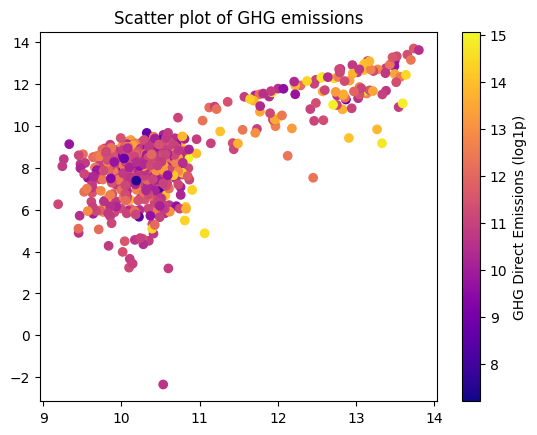

In [21]:
# 散布図を描画
scatter = plt.scatter(x=df['TRI_13_log1p'], y=df['TRI_diff_13-12_log1p'],
                      c=df['GHG_Direct_Emissions_14_in_metric_tons_log1p'], cmap='plasma')

plt.colorbar(scatter, label='GHG Direct Emissions (log1p)')
plt.title('Scatter plot of GHG emissions')
plt.show()

In [22]:
# GHG/TRIの特徴量
df['GHG_TRI_rate_10'] = np.where(
    df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
    df['GHG_Direct_Emissions_10_in_metric_tons'] / df['TRI_Air_Emissions_10_in_lbs'],
    np.nan
)

df['GHG_TRI_rate_11'] = np.where(
    df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
    df['GHG_Direct_Emissions_11_in_metric_tons'] / df['TRI_Air_Emissions_11_in_lbs'],
    np.nan
)

df['GHG_TRI_rate_12'] = np.where(
    df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
    df['GHG_Direct_Emissions_12_in_metric_tons'] / df['TRI_Air_Emissions_12_in_lbs'],
    np.nan
)

df['GHG_TRI_rate_13'] = np.where(
    df['TRI_Air_Emissions_13_in_lbs'].notna() & (df['TRI_Air_Emissions_13_in_lbs'] != 0),
    df['GHG_Direct_Emissions_13_in_metric_tons'] / df['TRI_Air_Emissions_13_in_lbs'],
    np.nan
)


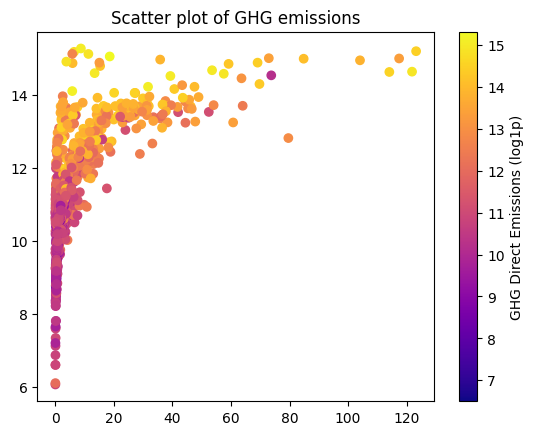

In [23]:
# 散布図を描画
scatter = plt.scatter(x=df['GHG_TRI_rate_13'], y=df['GHG_13_log1p'],
                      c=df['GHG_Direct_Emissions_14_in_metric_tons_log1p'], cmap='plasma')

plt.colorbar(scatter, label='GHG Direct Emissions (log1p)')
plt.title('Scatter plot of GHG emissions')
plt.show()

# Locationにかかわる特徴量

In [24]:
# import folium
# import matplotlib.cm as cm
# import matplotlib.colors as colors
# from IPython.display import display

# # 必要なデータを抽出し、新しいデータフレームを作成
# data = train_df[['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']].copy()

# # 緯度、経度、排出量のいずれかが欠損している行を削除
# data.dropna(subset=['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons'], inplace=True)

# # 各列のデータ型を float に変換
# for col in ['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']:
#     data[col] = data[col].astype(float)

# # 地図の中心をデータの緯度と経度の平均位置に設定
# map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
# m = folium.Map(location=map_center, zoom_start=5)

# # 排出量の最大値と最小値を取得
# max_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].max()
# min_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].min()

# # カラーマップを設定（排出量が少ない地点は黄色、多い地点は赤色で表示）
# colormap = cm.get_cmap('YlOrRd')
# normalize = colors.Normalize(vmin=min_emission, vmax=max_emission)

# # 各地点に対して、排出量に応じた色の円マーカーを作成し地図に追加
# for idx, row in data.iterrows():
#     # 排出量に基づいて色を設定
#     color = colors.rgb2hex(colormap(normalize(row['GHG_Direct_Emissions_14_in_metric_tons'])))

#     # 円マーカーを作成
#     folium.CircleMarker(
#         location=[row['Latitude'], row['Longitude']],  # 緯度・経度
#         radius=5,  # 円のサイズ
#         popup=f"Emissions: {row['GHG_Direct_Emissions_14_in_metric_tons']}",  # ポップアップに排出量を表示
#         color=color,  # 枠の色
#         fill=True,  # 円を塗りつぶす
#         fill_color=color  # 塗りつぶしの色
#     ).add_to(m)

# # 地図を表示（Jupyter Notebook 上で表示可能）
# display(m)


GHGが高い場所はまばら。地域差や業種に集約できる可能性はあり。
欠損値はそのままとして進める。

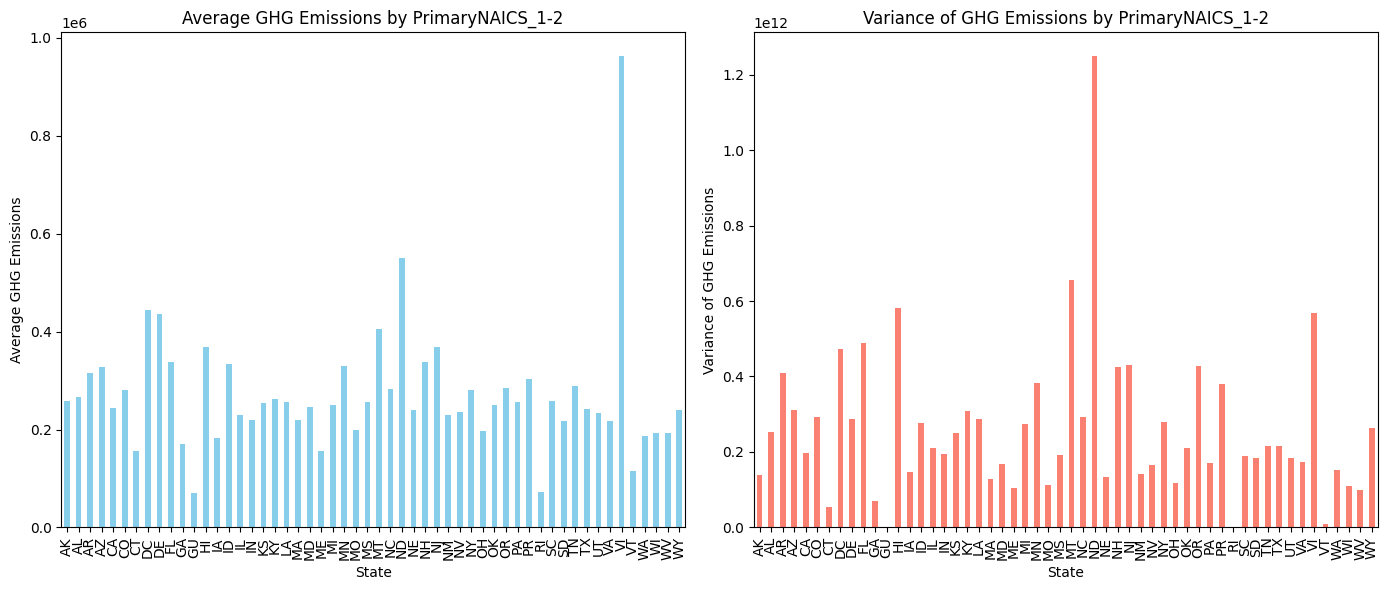

In [25]:
# Stateの特徴量
grouped = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons'].agg(['mean', 'var'])

# グラフの設定
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 平均のプロット
grouped['mean'].plot(kind='bar', ax=ax[0], color='skyblue', title='Average GHG Emissions by PrimaryNAICS_1-2')
ax[0].set_ylabel('Average GHG Emissions')

# 分散のプロット
grouped['var'].plot(kind='bar', ax=ax[1], color='salmon', title='Variance of GHG Emissions by PrimaryNAICS_1-2')
ax[1].set_ylabel('Variance of GHG Emissions')

plt.tight_layout()
plt.show()

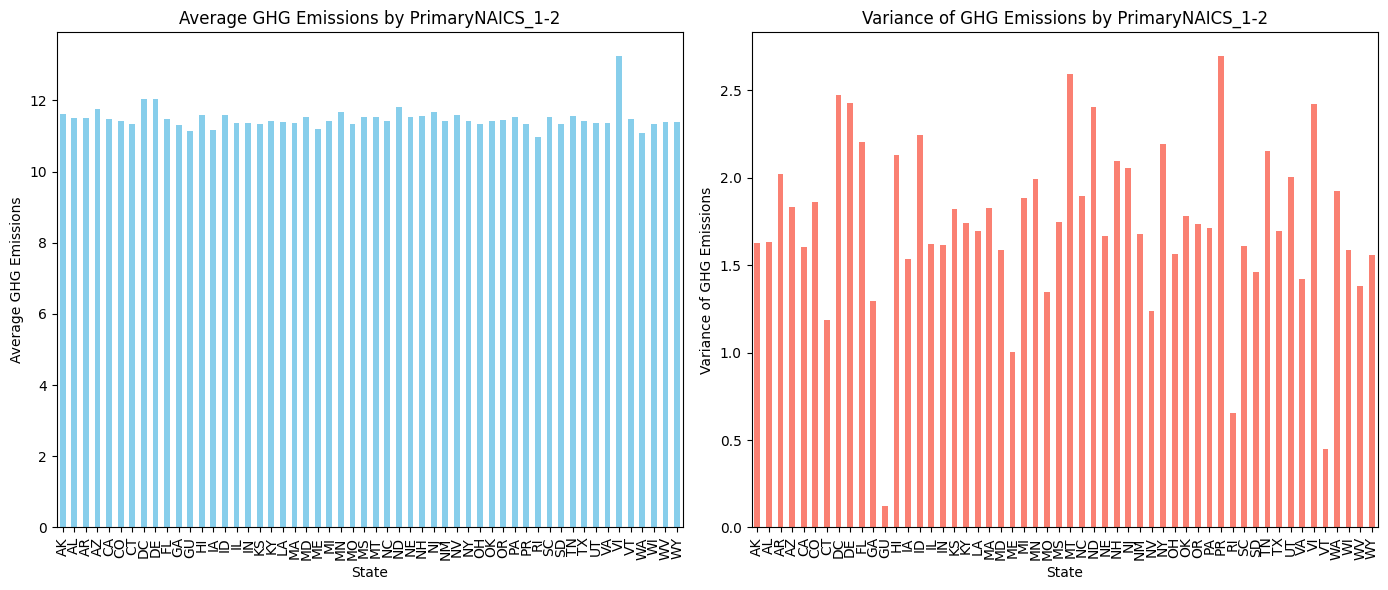

In [26]:
# Stateの特徴量
grouped = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons_log1p'].agg(['mean', 'var'])

# グラフの設定
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 平均のプロット
grouped['mean'].plot(kind='bar', ax=ax[0], color='skyblue', title='Average GHG Emissions by PrimaryNAICS_1-2')
ax[0].set_ylabel('Average GHG Emissions')

# 分散のプロット
grouped['var'].plot(kind='bar', ax=ax[1], color='salmon', title='Variance of GHG Emissions by PrimaryNAICS_1-2')
ax[1].set_ylabel('Variance of GHG Emissions')

plt.tight_layout()
plt.show()

In [27]:
# ターゲットエンコーディング（State）

# Stateごとの平均、分散、変動係数の計算
grouped = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons'].agg(['mean', 'var'])
grouped['std'] = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons'].std()
grouped['cv'] = grouped['std'] / grouped['mean']  # 変動係数

# dfにターゲットエンコーディングを適用
df = df.merge(grouped[['mean', 'var', 'cv']], on='State', how='left')
df.rename(columns={'mean': 'State_GHG_mean', 'var': 'State_GHG_var', 'cv': 'State_GHG_cv'}, inplace=True)

# Stateごとの平均、分散、変動係数の計算
grouped_log1p = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons_log1p'].agg(['mean', 'var'])
grouped_log1p['std'] = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons'].std()
grouped_log1p['cv'] = grouped['std'] / grouped['mean']  # 変動係数

# dfにターゲットエンコーディングを適用
df = df.merge(grouped_log1p[['mean', 'var', 'cv']], on='State', how='left')
df.rename(columns={'mean': 'State_GHG_mean_log1p', 'var': 'State_GHG_var_log1p', 'cv': 'State_GHG_cv_log1p'}, inplace=True)

# df.columns.tolist()

# industryにかかわる特徴量

'PrimaryNAICS'について

数字に応じたグループあり。
特に最初の2文字が業種を表す。

In [28]:
# PrimaryNAICSの最初の２文字の分類
naics_types      = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}

# PrimaryNAICSを文字数ごとに分割
df['PrimaryNAICS_1-2'] = df['PrimaryNAICS'].astype(str).str[:2].astype(int)
df['PrimaryNAICS_1-3'] = df['PrimaryNAICS'].astype(str).str[:3].astype(int)
df['PrimaryNAICS_1-4'] = df['PrimaryNAICS'].astype(str).str[:4].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
df['NAICS_Type'] = df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# SecondPrimaryNAICSを分類してカテゴリ変数へ変換
df['SecondPrimaryNAICS_1-2'] = pd.to_numeric(df['SecondPrimaryNAICS'].astype(str).str[:2], errors='coerce')
df['Sub_NAICS_Type'] = df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

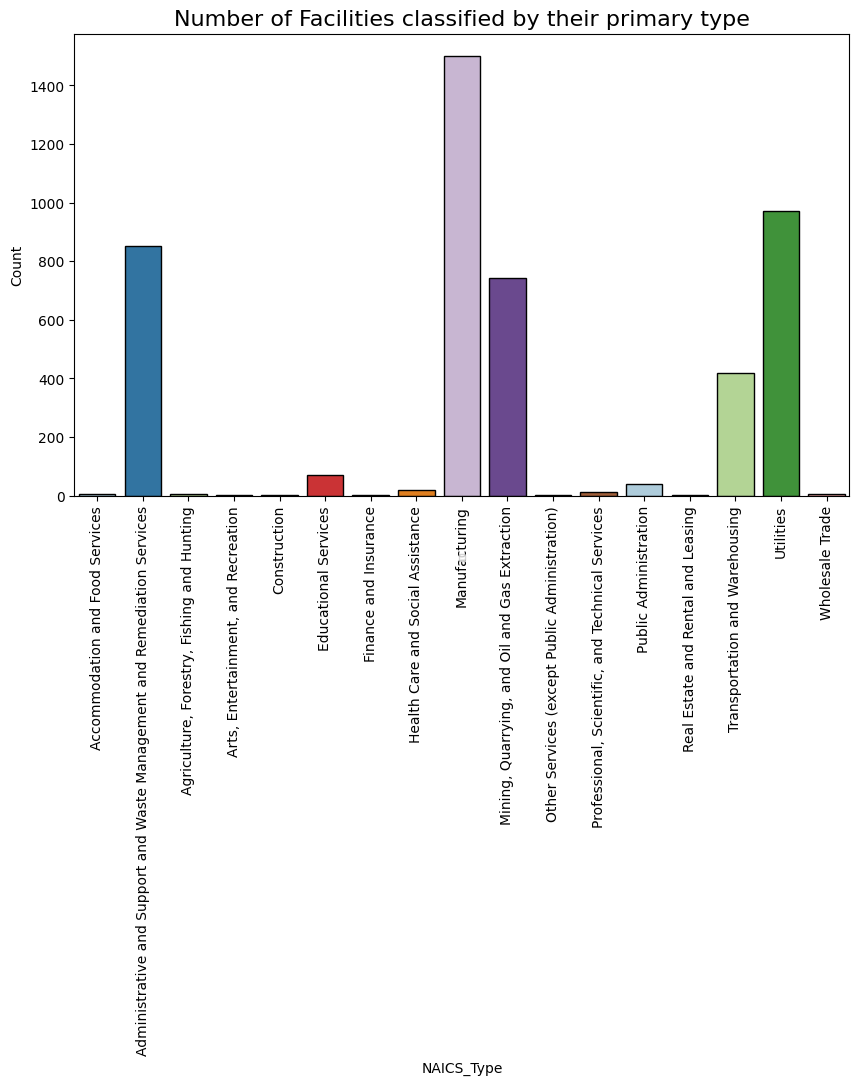

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# データの集計
df_summary = train_df.groupby('NAICS_Type').size().reset_index(name='count')
df_summary = df_summary.sort_values('count', ascending=False)

# カラーパレットの設定
colors = sns.color_palette("Paired", n_colors=20)

# プロットの作成
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=df_summary,
    x='NAICS_Type',
    y='count',
    palette=colors,
    edgecolor='black'
)

# Y軸を対数スケールに設定
# plt.yscale('log')

# タイトルとラベルの設定
plt.title('Number of Facilities classified by their primary type', fontsize=16)
plt.xlabel('NAICS_Type')
plt.ylabel('Count')

# 軸と凡例の設定
plt.xticks(rotation=90)  # x軸のラベルを回転して表示
plt.legend(
    title='',
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=5,
    fontsize=6
)

# グラフの表示
plt.tight_layout()
plt.show()


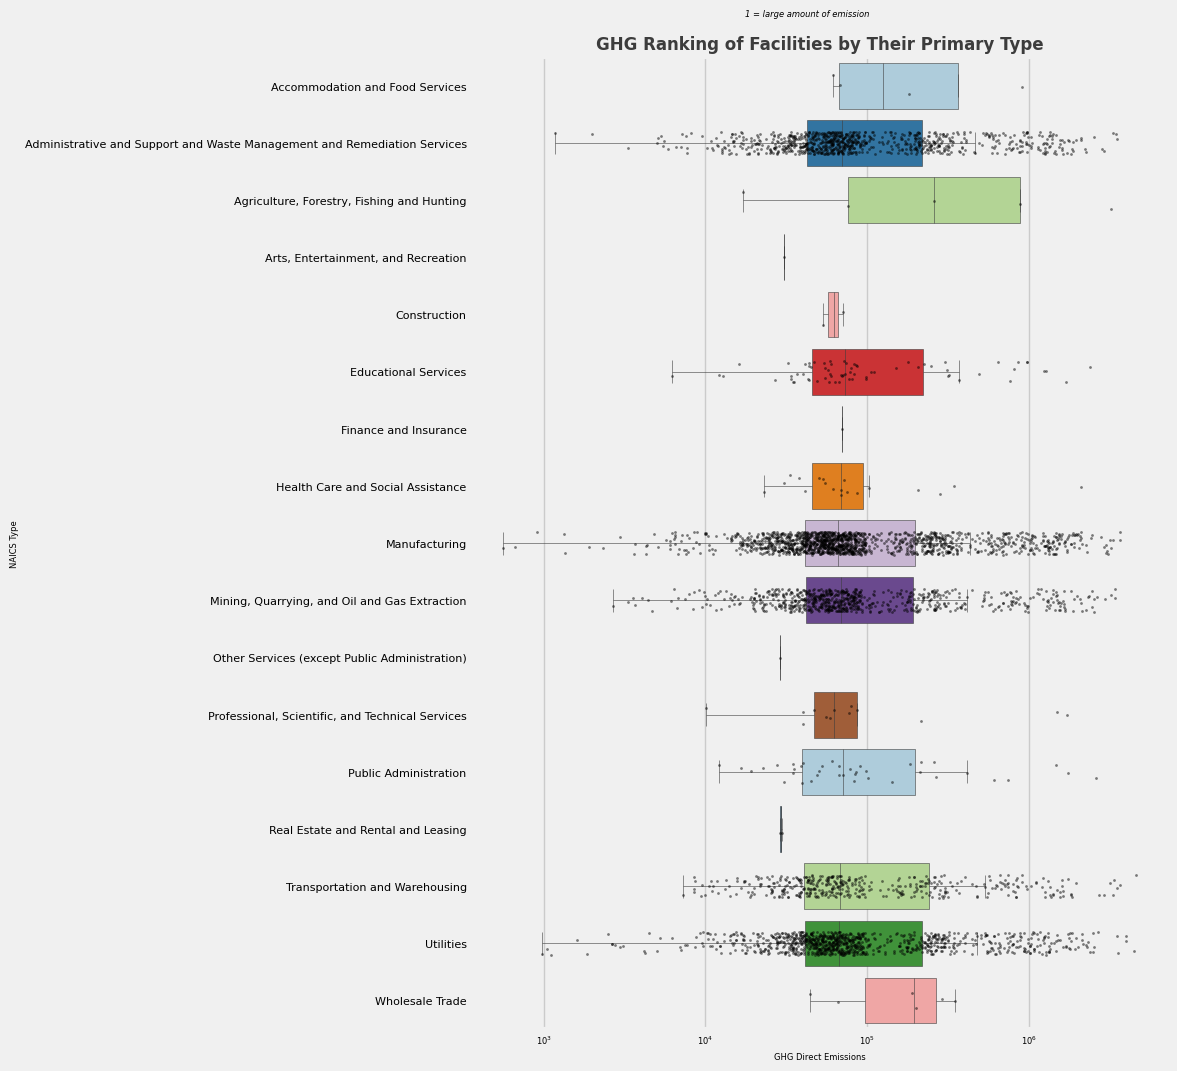

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

# Assuming df is already loaded as a pandas DataFrame
ghg_df = train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons']]

# Set the style to replicate theme_fivethirtyeight
plt.style.use('fivethirtyeight')

# Create color palette
palette = sns.color_palette("Paired", n_colors=20)

# Set up the figure
plt.figure(figsize=(8, 12))

# Create the boxplot with jitter
sns.boxplot(
    y='NAICS_Type',
    x='GHG_Direct_Emissions_14_in_metric_tons',
    data=ghg_df,
    palette=palette,
    linewidth=0.4,
    fliersize=0,
    whis=1.5
)
sns.stripplot(
    y='NAICS_Type',
    x='GHG_Direct_Emissions_14_in_metric_tons',
    data=ghg_df,
    color='black',
    size=2,
    jitter=0.2,
    alpha=0.5
)

# Set titles and labels
plt.title("GHG Ranking of Facilities by Their Primary Type", fontsize=12, fontweight='bold', color="#3C3C3C")
plt.suptitle("1 = large amount of emission", fontsize=6, style='italic', y=0.92)

# Hide legend
plt.legend([], [], frameon=False)

# Adjust layout
plt.tight_layout()

# Y軸を対数スケールに設定
plt.xscale('log')

# Show the plot
plt.xlabel('GHG Direct Emissions', fontsize=6)
plt.ylabel('NAICS Type', fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=8)

plt.show()


In [31]:
# dfからprimary.industryとRank.TRI.14の列を選択し、欠損値を除外
df_filtered = train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons']].dropna()

# primary.industryでグループ化し、countとmeanを計算
df_summary = (df_filtered
              .groupby('NAICS_Type')
              .agg(count=('GHG_Direct_Emissions_14_in_metric_tons', 'size'), meanTri=('GHG_Direct_Emissions_14_in_metric_tons', 'mean'))
              .reset_index()
              .sort_values(by='count', ascending=False))

df_summary

,NAICS_Type,count,meanTri
8,Manufacturing,1502,242241.779348
15,Utilities,973,249955.050176
1,Administrative and Support and Waste Managemen...,853,250811.821049
9,"Mining, Quarrying, and Oil and Gas Extraction",744,252928.100287
14,Transportation and Warehousing,420,293777.481256
5,Educational Services,70,251472.609850
12,Public Administration,39,265045.537769
7,Health Care and Social Assistance,19,199722.193130
11,"Professional, Scientific, and Technical Services",13,306494.681102
16,Wholesale Trade,6,189978.439316


データ数の多い５つのグループは若干の平均には違いはあるものの、データの分布数は全体と変わらないように見受けられる。

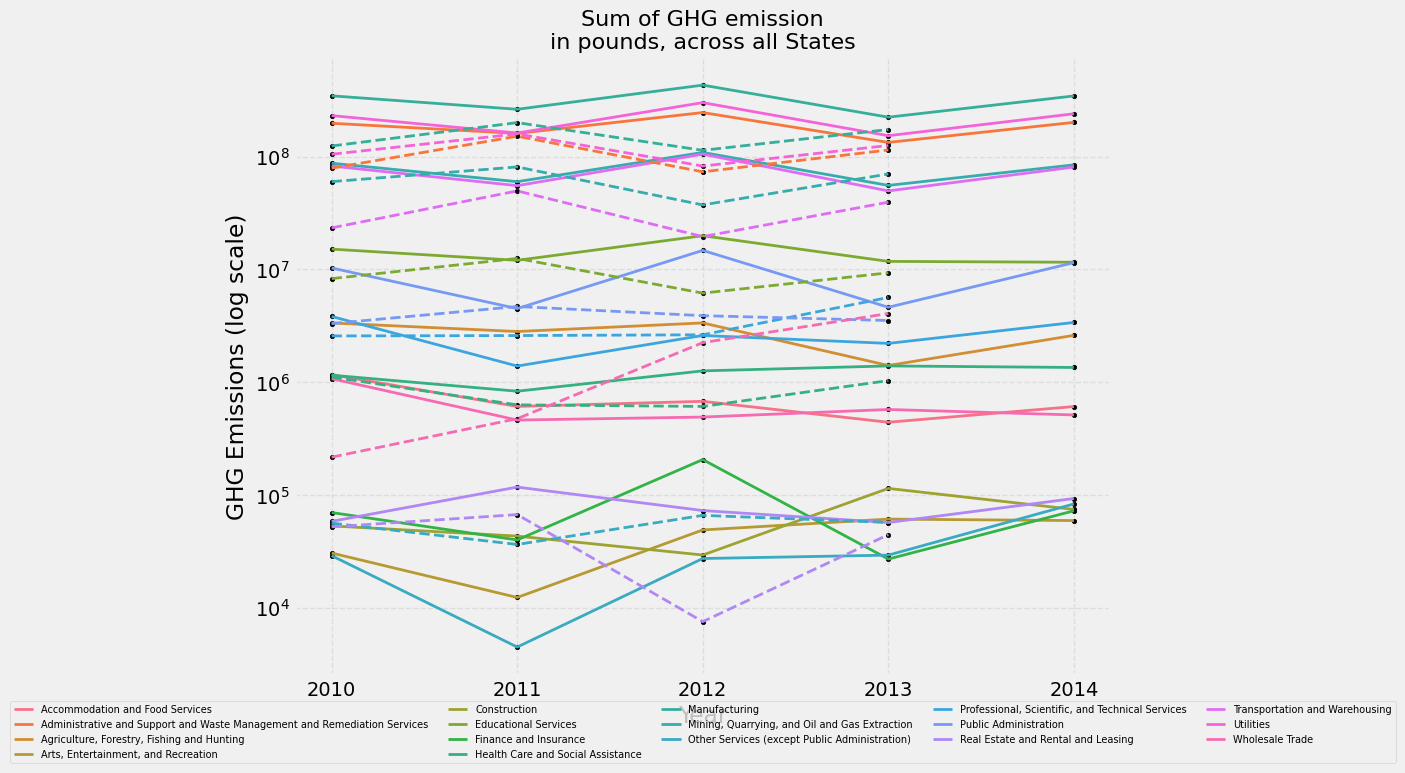

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_sum
ghg_sum = (
    train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'GHG.direct.emissions.10': 'sum.GHG.10',
                     'GHG.direct.emissions.11': 'sum.GHG.11',
                     'GHG.direct.emissions.12': 'sum.GHG.12',
                     'GHG.direct.emissions.13': 'sum.GHG.13',
                     'GHG.direct.emissions.14': 'sum.GHG.14'})
)

# Transpose and prepare for plotting
temp_ghg = ghg_sum.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_sum['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Data preparation for test GHG_sum
test_ghg_sum = (
    test_df[['NAICS_Type', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'sum.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'sum.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'sum.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'sum.GHG.13'})
)

# Transpose and prepare for plotting
temp_test_ghg = test_ghg_sum.drop(columns='NAICS_Type').transpose()
temp_test_ghg.columns = test_ghg_sum['NAICS_Type']
temp_test_ghg.reset_index(inplace=True)
temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_test_ghg['year'] = [2010, 2011, 2012, 2013]

temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Plotting with seaborn and matplotlib
plt.figure(figsize=(12, 8))
unique_industries = pd.concat([temp_ghg_melt['NAICS_Type'], temp_test_ghg_melt['NAICS_Type']]).unique()
colors = sns.color_palette('husl', len(unique_industries))
color_dict = dict(zip(unique_industries, cycle(colors)))

# Plot original GHG emissions
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Plot test GHG emissions with dashed lines (no legend)
sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1, linestyle='--', legend=False)
plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color='black', s=10, alpha=1)

plt.yscale('log')
plt.title('Sum of GHG emission\nin pounds, across all States', fontsize=16)
plt.xlabel('Year')
plt.ylabel('GHG Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


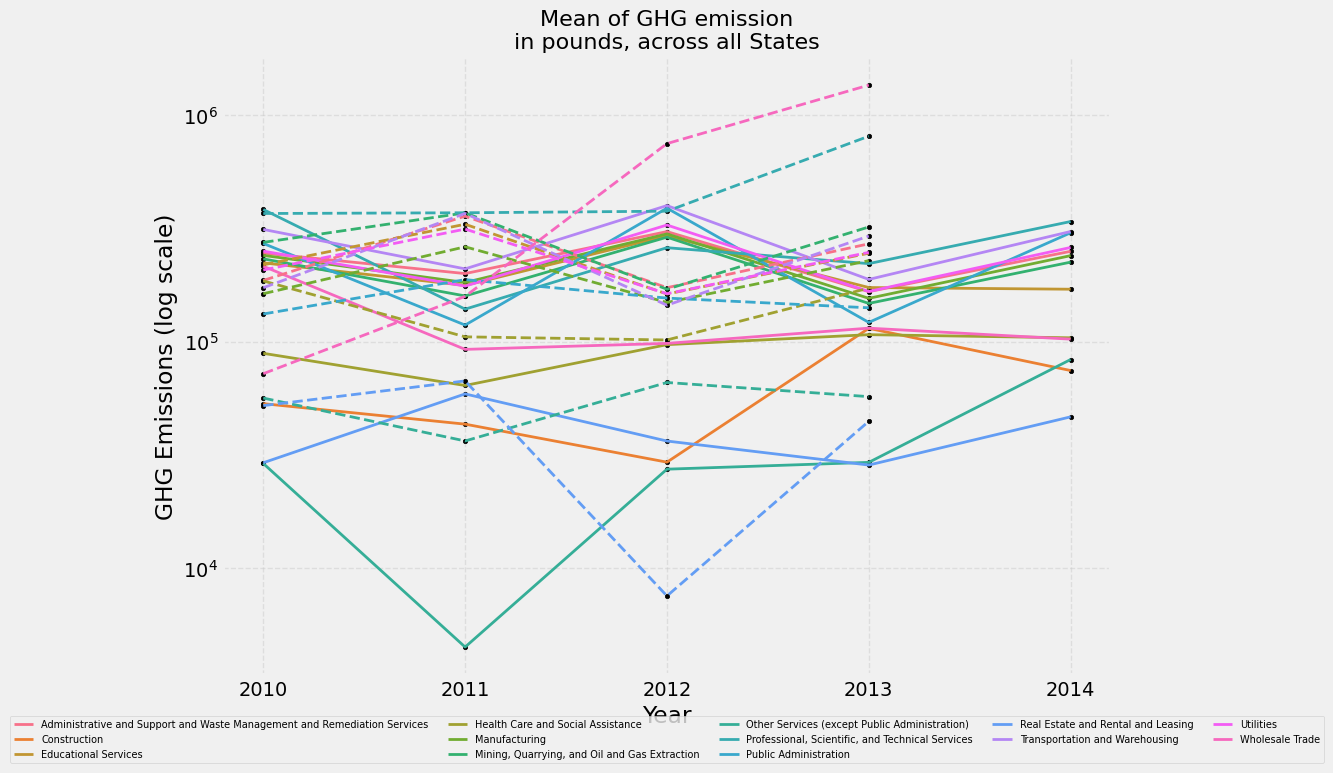

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_mean
ghg_mean = (
    train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .mean()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13',
                     'GHG_Direct_Emissions_14_in_metric_tons': 'mean.GHG.14'})
)

# Transpose and prepare for plotting
temp_ghg = ghg_mean.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_mean['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='primary.industry', value_name='value')

# Data preparation for test GHG_mean
test_ghg_mean = (
    test_df[['NAICS_Type', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .mean()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13'})
)

# Transpose and prepare for plotting
temp_test_ghg = test_ghg_mean.drop(columns='NAICS_Type').transpose()
temp_test_ghg.columns = test_ghg_mean['NAICS_Type']
temp_test_ghg.reset_index(inplace=True)
temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_test_ghg['year'] = [2010, 2011, 2012, 2013]

temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Filter temp_ghg_melt and temp_merged_ghg_melt to include only NAICS_Type present in test data
valid_naics_types = test_ghg_mean['NAICS_Type'].unique()
temp_ghg_melt = temp_ghg_melt[temp_ghg_melt['primary.industry'].isin(valid_naics_types)]
temp_test_ghg_melt = temp_test_ghg_melt[temp_test_ghg_melt['NAICS_Type'].isin(valid_naics_types)]

# Plotting with seaborn and matplotlib
plt.figure(figsize=(12, 8))
unique_industries = pd.concat([temp_ghg_melt['primary.industry'], temp_test_ghg_melt['NAICS_Type']]).unique()
colors = sns.color_palette('husl', len(unique_industries))
color_dict = dict(zip(unique_industries, cycle(colors)))

# Plot original GHG emissions with solid lines (train)
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='primary.industry', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Plot test GHG emissions with dashed lines (test, no legend)
sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1, linestyle='--', legend=False)
plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color='black', s=10, alpha=1)

plt.yscale('log')
plt.title('Mean of GHG emission\nin pounds, across all States', fontsize=16)
plt.xlabel('Year')
plt.ylabel('GHG Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


合計値や平均なので一概にはいえないが、上位6つのデータでは、trainデータで2010,2012 vs 2011,2013の構図ができている。単純に戻るを回すと2012や2010が重要度が高い理由になっていると思われる。対して、testデータはtrainデータと真逆の挙動を示しており、trainデータを信頼しすぎると、精度が背反する可能性が高い。

In [34]:
# 各年の差から予測
df['GHG_diff_13_12'] = df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']
df['GHG_diff_12_11'] = df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']
df['GHG_diff_11_10'] = df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']

df['GHG_from_diff_13_12'] = df['GHG_Direct_Emissions_13_in_metric_tons'] + df['GHG_diff_13_12']
df['GHG_from_diff_12_11'] = df['GHG_Direct_Emissions_13_in_metric_tons'] + df['GHG_diff_12_11']

# 直近トレンドをエンコーディング
df['trend_13_12'] = np.where(df['GHG_diff_13_12'] > 0, 1, 0)
df['trend_13_11'] = np.where((df['GHG_diff_13_12'] > 0) & (df['GHG_diff_12_11'] > 0), 1, 0)

In [35]:
# dfからprimary.industryとRank.TRI.14の列を選択し、欠損値を除外
df_filtered = train_df[['NAICS_Type', 'TRI_Air_Emissions_13_in_lbs']].dropna()

# primary.industryでグループ化し、countとmeanを計算
df_summary = (df_filtered
              .groupby('NAICS_Type')
              .agg(count=('TRI_Air_Emissions_13_in_lbs', 'size'), meanTri=('TRI_Air_Emissions_13_in_lbs', 'mean'))
              .reset_index()
              .sort_values(by='count', ascending=False))

df_summary

,NAICS_Type,count,meanTri
8,Manufacturing,1262,54932.424354
15,Utilities,327,63195.604577
9,"Mining, Quarrying, and Oil and Gas Extraction",20,24554.673169
12,Public Administration,18,28348.151346
16,Wholesale Trade,3,34440.297642
1,Administrative and Support and Waste Managemen...,2,206397.851863
11,"Professional, Scientific, and Technical Services",2,15905.041731
14,Transportation and Warehousing,1,32616.566141
5,Educational Services,0,NaN
6,Finance and Insurance,0,NaN


In [36]:
# dfからprimary.industryとRank.TRI.14の列を選択し、欠損値を除外
df_filtered = test_df[['NAICS_Type', 'TRI_Air_Emissions_13_in_lbs']].dropna()

# primary.industryでグループ化し、countとmeanを計算
df_summary = (df_filtered
              .groupby('NAICS_Type')
              .agg(count=('TRI_Air_Emissions_13_in_lbs', 'size'), meanTri=('TRI_Air_Emissions_13_in_lbs', 'mean'))
              .reset_index()
              .sort_values(by='count', ascending=False))

df_summary

,NAICS_Type,count,meanTri
4,Manufacturing,650,47436.901056
11,Utilities,197,61593.783965
5,"Mining, Quarrying, and Oil and Gas Extraction",12,29710.991157
8,Public Administration,7,30170.225615
0,Administrative and Support and Waste Managemen...,4,147963.783117
7,"Professional, Scientific, and Technical Services",3,31248.622434
12,Wholesale Trade,1,352529.159773
1,Construction,0,NaN
2,Educational Services,0,NaN
3,Health Care and Social Assistance,0,NaN


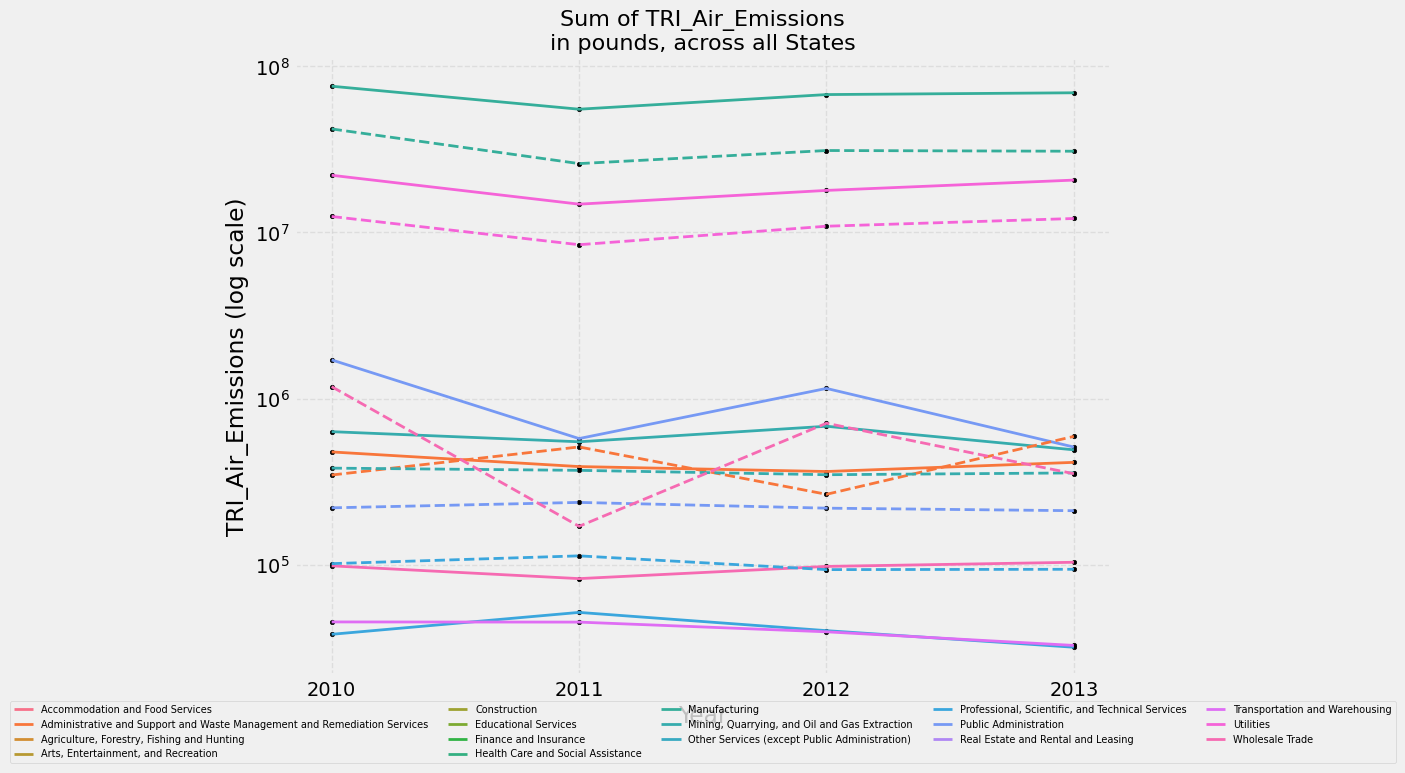

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_sum
ghg_sum = (
    train_df[['NAICS_Type', 'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'TRI_Air_Emissions_10_in_lbs': 'sum.TRI.10',
                     'TRI_Air_Emissions_11_in_lbs': 'sum.TRI.11',
                     'TRI_Air_Emissions_12_in_lbs': 'sum.TRI.12',
                     'TRI_Air_Emissions_13_in_lbs': 'sum.TRI.13',})
)

# Transpose and prepare for plotting
temp_ghg = ghg_sum.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_sum['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Data preparation for test GHG_sum
test_ghg_sum = (
    test_df[['NAICS_Type', 'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'TRI_Air_Emissions_10_in_lbs': 'sum.TRI.10',
                     'TRI_Air_Emissions_11_in_lbs': 'sum.TRI.11',
                     'TRI_Air_Emissions_12_in_lbs': 'sum.TRI.12',
                     'TRI_Air_Emissions_13_in_lbs': 'sum.TRI.13',})
)


# Transpose and prepare for plotting
temp_test_ghg = test_ghg_sum.drop(columns='NAICS_Type').transpose()
temp_test_ghg.columns = test_ghg_sum['NAICS_Type']
temp_test_ghg.reset_index(inplace=True)
temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_test_ghg['year'] = [2010, 2011, 2012, 2013]

temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Plotting with seaborn and matplotlib
plt.figure(figsize=(12, 8))
unique_industries = pd.concat([temp_ghg_melt['NAICS_Type'], temp_test_ghg_melt['NAICS_Type']]).unique()
colors = sns.color_palette('husl', len(unique_industries))
color_dict = dict(zip(unique_industries, cycle(colors)))

# Plot original GHG emissions
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Plot test GHG emissions with dashed lines (no legend)
sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1, linestyle='--', legend=False)
plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color='black', s=10, alpha=1)

plt.yscale('log')
plt.title('Sum of TRI_Air_Emissions\nin pounds, across all States', fontsize=16)
plt.xlabel('Year')
plt.ylabel('TRI_Air_Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


データ数が少なく、十分な特徴量を作成するのが難しそう。上位2つのデータは傾向が似ている。GHGのトレンドとは大きく異なる。


In [38]:
train_df, test_df = split_train_test(df)

Peaks positions: [10.99798883 12.28588197 13.57377511]
thresholds: [11.641935402161494, 12.929828539112622]


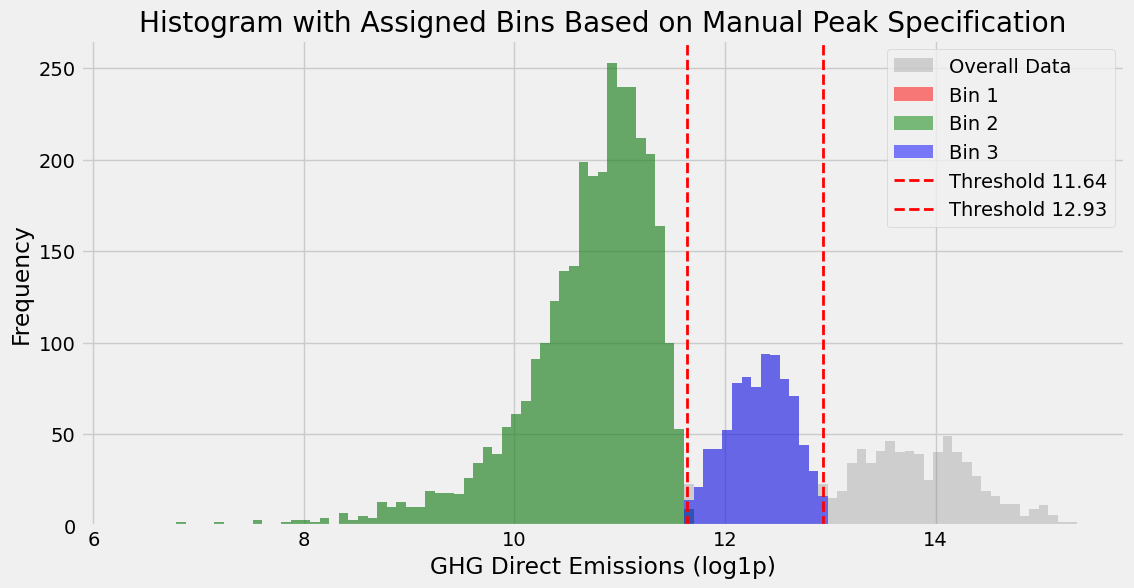

In [39]:
from scipy.signal import find_peaks

# ヒストグラムを作成し、ピークの検出
hist, bin_edges = np.histogram(train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'], bins=28)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
peaks, _ = find_peaks(hist, distance=3)  # ピークの検出

print(f"Peaks positions: {bin_centers[peaks]}")
# # ピークの位置を手動で指定
peaks = peaks.tolist()

# ピークの位置に基づいて閾値を設定
if len(peaks) == 3:
    thresholds = [(bin_centers[peaks[i]] + bin_centers[peaks[i + 1]]) / 2 for i in range(len(peaks) - 1)]
    print(f"thresholds: {thresholds}")

    # 各データポイントがどのビンに属するかを判断する関数
    def assign_bin(value):
        if np.isnan(value):  # np.isnan() を使って NaN のチェックを行う
            return 0
        elif value < thresholds[0]:
            return 1  # 第1ピークに属する
        elif value < thresholds[1]:
            return 2  # 第2ピークに属する
        else:
            return 3  # 第3ピークに属する

    # 各データポイントにラベルを適用
    labels = train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'].apply(assign_bin)

    # 共通のビン境界を作成
    bins = np.linspace(train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'].min(),
                       train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'].max(), 100)

    # 全体のヒストグラムをプロット
    plt.figure(figsize=(12, 6))
    plt.hist(train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'], bins=bins, alpha=0.3, color='gray', label='Overall Data', density=False)

    # 各ビンに属するデータを可視化
    colors = ['red', 'green', 'blue']
    for i in range(3):
        plt.hist(train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'][labels == i], bins=bins, alpha=0.5, color=colors[i], label=f'Bin {i+1}', density=False)

    # 閾値に縦線を描画
    for threshold in thresholds:
        plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold {threshold:.2f}')

    plt.xlabel('GHG Direct Emissions (log1p)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Histogram with Assigned Bins Based on Manual Peak Specification')
    plt.show()

#     Peaks positions: [11.19761227 12.2794425  13.72188282]
# thresholds: [11.738527387432828, 13.000662661644935]

In [40]:
def plot_histograms_with_thresholds(train_df, test_df, column_num, thresholds, bins=100, x_max=16, x_min=0):
    # カラム名を作成
    col_log_name = f'GHG_Direct_Emissions_{column_num}_in_metric_tons_log1p'

    # 共通のビン境界を作成
    bins = np.linspace(min(train_df[col_log_name].min(), test_df[col_log_name].min()),
                       max(train_df[col_log_name].max(), test_df[col_log_name].max()), bins)

    # ヒストグラムのプロット
    plt.figure(figsize=(12, 6))
    plt.hist(train_df[col_log_name], bins=bins, alpha=0.5, color='blue', label='Train Data', density=False, edgecolor='black')
    plt.hist(test_df[col_log_name], bins=bins, alpha=0.5, color='orange', label='Test Data', density=False, edgecolor='black')

    # 閾値に縦線を描画
    for threshold in thresholds:
        plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold {threshold:.2f}')

    # x軸の範囲設定
    plt.xlim(left=x_min, right=x_max)
    plt.xlabel(f'GHG Direct Emissions {column_num} (log1p)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(f'Histogram of Train and Test Data for GHG Direct Emissions {column_num}')
    plt.show()

In [41]:
def trans_log1p(df):
  for i in range(10, 14):
    col_name = f'GHG_Direct_Emissions_{i}_in_metric_tons'
    col_log_name = f'{col_name}_log1p'

    df[col_log_name] = np.log1p(df[col_name])
  return df

train_df = trans_log1p(train_df)
test_df = trans_log1p(test_df)

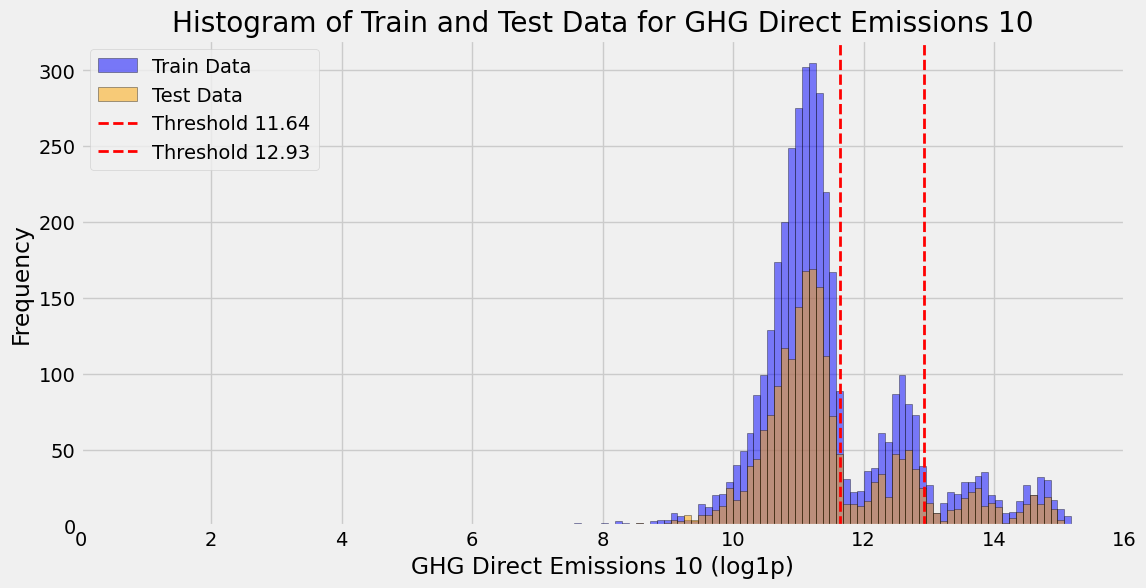

In [42]:
plot_histograms_with_thresholds(train_df, test_df, column_num=10, thresholds=thresholds)

In [43]:
def assign_bin(value):
    if np.isnan(value):  # np.isnan() を使って NaN のチェックを行う
        return 0
    elif value < thresholds[0]:
        return 1  # 第1ピークに属する
    elif value < thresholds[1]:
        return 2  # 第2ピークに属する
    else:
        return 3  # 第3ピークに属する

thresholds=[11.738527387432828, 13.000662661644935]

def ghg_binning(df):
    df['GHG_10_bins'] = df['GHG_Direct_Emissions_10_in_metric_tons_log1p'].apply(assign_bin)
    df['GHG_11_bins'] = df['GHG_Direct_Emissions_11_in_metric_tons_log1p'].apply(assign_bin)
    df['GHG_12_bins'] = df['GHG_Direct_Emissions_12_in_metric_tons_log1p'].apply(assign_bin)
    df['GHG_13_bins'] = df['GHG_Direct_Emissions_13_in_metric_tons_log1p'].apply(assign_bin)
    return df

train_df = ghg_binning(train_df)
test_df = ghg_binning(test_df)

# データインプット

In [44]:
train_df.columns.tolist()

['Unnamed: 0',
 'FacilityName',
 'Latitude',
 'Longitude',
 'LocationAddress',
 'City',
 'State',
 'ZIP',
 'County',
 'FIPScode',
 'PrimaryNAICS',
 'SecondPrimaryNAICS',
 'IndustryType',
 'TRI_Air_Emissions_10_in_lbs',
 'TRI_Air_Emissions_11_in_lbs',
 'TRI_Air_Emissions_12_in_lbs',
 'TRI_Air_Emissions_13_in_lbs',
 'GHG_Direct_Emissions_10_in_metric_tons',
 'GHG_Direct_Emissions_11_in_metric_tons',
 'GHG_Direct_Emissions_12_in_metric_tons',
 'GHG_Direct_Emissions_13_in_metric_tons',
 'GHG_Direct_Emissions_14_in_metric_tons',
 'GHG_Direct_Emissions_14_in_metric_tons_log1p',
 'is_train',
 'GHG_10_log1p',
 'GHG_11_log1p',
 'GHG_12_log1p',
 'GHG_13_log1p',
 'TRI_diff_11-10',
 'TRI_diff_12-11',
 'TRI_diff_13-12',
 'TRI_Growth_Rate_11',
 'TRI_Growth_Rate_12',
 'TRI_Growth_Rate_13',
 'TRI_10_log1p',
 'TRI_11_log1p',
 'TRI_12_log1p',
 'TRI_13_log1p',
 'TRI_diff_11-10_log1p',
 'TRI_diff_12-11_log1p',
 'TRI_diff_13-12_log1p',
 'GHG_TRI_rate_10',
 'GHG_TRI_rate_11',
 'GHG_TRI_rate_12',
 'GHG_TRI_r

In [45]:
features = [
                        'TRI_Air_Emissions_10_in_lbs',
                        'TRI_Air_Emissions_11_in_lbs',
                    'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs','PrimaryNAICS',
                    'GHG_Direct_Emissions_10_in_metric_tons',
                        'GHG_Direct_Emissions_11_in_metric_tons',
                    'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons',
                        'Latitude','Longitude',
                        'TRI_diff_11-10',
                        'TRI_diff_12-11','TRI_diff_13-12',
                        'TRI_Growth_Rate_11',
                        'TRI_Growth_Rate_12','TRI_Growth_Rate_13',
                        'NAICS_Type',
                        'GHG_diff_13_12',
 'GHG_diff_12_11',
 'GHG_diff_11_10',
#  'GHG_from_diff_13_12',
#  'GHG_from_diff_12_11',
#  'trend_13_12',
#  'trend_13_11',
#                         # 'State_GHG_mean', 'State_GHG_var',
#                         'State_GHG_cv'
                         'GHG_10_bins',
 'GHG_11_bins',
 'GHG_12_bins',
 'GHG_13_bins'
]

In [46]:


def convert_object_to_category(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')
    return df

train_df = convert_object_to_category(train_df)
test_df = convert_object_to_category(test_df)


In [49]:
train_indices = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/train_indices.csv')
valid_indices = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/valid_indices.csv')

In [54]:
train = train_df[features]
target = train_df['GHG_Direct_Emissions_14_in_metric_tons']
test = test_df[features]

# インデックスで分けてデータセットを作成
train_indices = train_indices['train_indices'].dropna().astype(int).tolist()
valid_indices = valid_indices['valid_indices'].dropna().astype(int).tolist()

# インデックスで分けてデータセットを作成
X_train = train.loc[train_indices]
y_train = target.loc[train_indices]
X_valid = train.loc[valid_indices]
y_valid = target.loc[valid_indices]

------------------------------ fold 0 ------------------------------
Fold 0 Train RMSLE: 0.69873, Validation RMSLE: 0.70729
------------------------------ fold 1 ------------------------------
Fold 1 Train RMSLE: 0.69588, Validation RMSLE: 0.75780
------------------------------ fold 2 ------------------------------
Fold 2 Train RMSLE: 0.69893, Validation RMSLE: 0.72265
Final Model Train RMSLE: 0.69709, Validation RMSLE: 0.72541


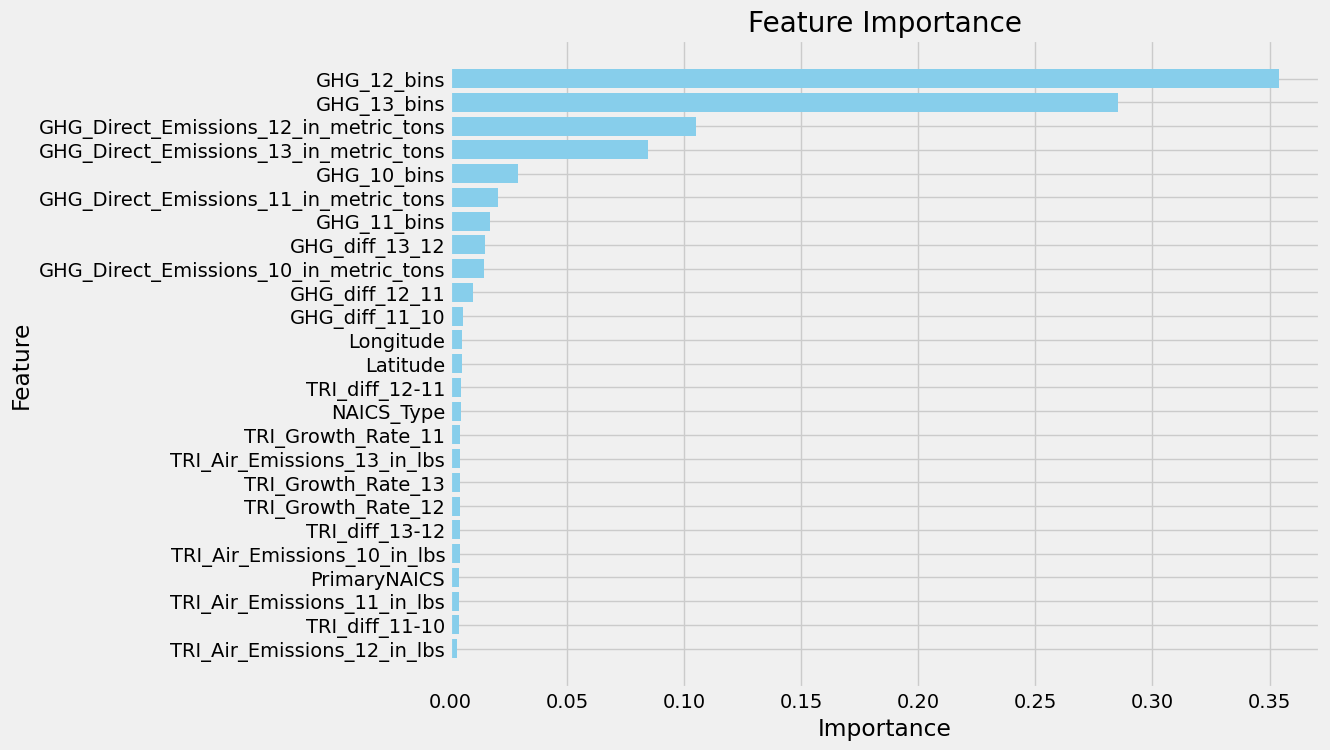

In [64]:
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

gc.collect()
np.random.seed(42)

# 新しいデータセット
train = train_df[features].loc[train_indices]
target = train_df['GHG_Direct_Emissions_14_in_metric_tons'].loc[train_indices]
valid = train_df[features].loc[valid_indices]
valid_target = train_df['GHG_Direct_Emissions_14_in_metric_tons'].loc[valid_indices]
test = test_df[features]

# valid_data を 3 分割
num_folds = 3
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = []
models = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(valid)):
    print(f"------------------------------ fold {fold} ------------------------------")

    # validデータを3分割し、1つをモデル用のvalid、残り2つをtrainに追加
    fold_valid = valid.iloc[valid_idx]
    fold_valid_target = valid_target.iloc[valid_idx]
    fold_unused_valid = valid.iloc[train_idx]
    fold_unused_valid_target = valid_target.iloc[train_idx]

    # trainデータを作成 (元のtrain_data と fold_unused_valid を結合)
    X_train = pd.concat([train, fold_unused_valid])
    y_train = pd.concat([target, fold_unused_valid_target])
    X_valid = fold_valid
    y_valid = fold_valid_target

    # モデルのパラメータ
    params1 = {
        'n_estimators': 549,
        'learning_rate': 0.008289310393873825,
        'subsample': 0.6594561397042182,
        'colsample_bytree': 0.6411024078584135,
        'reg_alpha': 0.6040913459999436,
        'reg_lambda': 3.0828495121526642,
        'max_depth': 4,
        'random_state': 42,
        'enable_categorical': True,
    }

    # モデルの作成
    model1 = XGBRegressor(**params1)

    # モデルの学習と予測
    _ = model1.fit(X_train, np.log1p(y_train))
    valid_preds1 = np.expm1(model1.predict(X_valid))
    train_preds1 = np.expm1(model1.predict(X_train))

    # RMSLEの計算
    rmsle1 = np.sqrt(mean_squared_log_error(y_valid, valid_preds1))
    tr_rmsle1 = np.sqrt(mean_squared_log_error(y_train, train_preds1))
    print(f"Fold {fold} Train RMSLE: {tr_rmsle1:.5f}, Validation RMSLE: {rmsle1:.5f}")

    # 結果を保存
    cv_results.append((tr_rmsle1, rmsle1))
    models.append(model1)

# すべてのデータを使ってモデルを評価
final_model = XGBRegressor(**params1)
_ = final_model.fit(train, np.log1p(target))
final_train_preds = np.expm1(final_model.predict(train))
final_valid_preds = np.expm1(final_model.predict(valid))

final_rmsle_train = np.sqrt(mean_squared_log_error(target, final_train_preds))
final_rmsle_valid = np.sqrt(mean_squared_log_error(valid_target, final_valid_preds))
print(f"Final Model Train RMSLE: {final_rmsle_train:.5f}, Validation RMSLE: {final_rmsle_valid:.5f}")

# テストデータに対する予測
test_predictions1 = np.expm1(final_model.predict(test))

# 特徴重要度の表示
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = train.columns
feature_importance_df["importance"] = final_model.feature_importances_
feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()


In [65]:
submit = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/sample_submission.csv', header=None)
submit[1] = test_predictions1
submit.head()

,0,1
0,4655,43420.250000
1,4656,329954.375000
2,4657,40904.566406
3,4658,27900.158203
4,4659,48042.742188


# ハイパラ調整（Optuna）

In [86]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 4.5 MB/s eta 0:00:00


In [104]:
import optuna
from sklearn.metrics import mean_squared_log_error
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import gc


# Clear memory
gc.collect()
np.random.seed(42)

# Prepare new dataset
train = train_df[features].loc[train_indices]
target = train_df['GHG_Direct_Emissions_14_in_metric_tons'].loc[train_indices]
valid = train_df[features].loc[valid_indices]
valid_target = train_df['GHG_Direct_Emissions_14_in_metric_tons'].loc[valid_indices]
test = test_df[features]


def objective(trial, train, target, valid, valid_target):
  # Split valid_data into 3 folds
  num_folds = 3
  kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
  cv_results = []
  models = []

  # Track overall training and validation RMSLE across folds
  overall_train_rmsle_sum = 0
  overall_valid_rmsle_sum = 0

  for fold, (train_idx, valid_idx) in enumerate(kf.split(valid)):
      # print(f" fold {fold} ")

      # Split valid data into train and validation for this fold
      fold_valid = valid.iloc[valid_idx]
      fold_valid_target = valid_target.iloc[valid_idx]
      fold_unused_valid = valid.iloc[train_idx]
      fold_unused_valid_target = valid_target.iloc[train_idx]

      # Create train data (original train data + unused validation data)
      X_train = pd.concat([train, fold_unused_valid])
      y_train = pd.concat([target, fold_unused_valid_target])
      X_valid = fold_valid
      y_valid = fold_valid_target


      # Optunaで探索するパラメータ
      lgbm_params = {
          "n_estimators": trial.suggest_int("n_estimators", 80, 100),
          "max_depth": 3,
          "learning_rate": trial.suggest_loguniform("learning_rate", 0.06, 0.08),
          'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.01, 0.03),
          'lambda_l2': trial.suggest_loguniform('lambda_l2', 1.0, 4.0),
          "random_state": 42,
          'objective': 'regression',
          'metric': 'rmse',
          'boosting_type': 'gbdt',
          'verbose': -1,
          "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 30, 50),
          "max_bin": trial.suggest_int("max_bin", 150, 200),
      }

      model1 = LGBMRegressor(**lgbm_params)
      # Train Model
      model1.fit(
          X_train,
          np.log1p(y_train),
          eval_set=[(X_valid, y_valid)],
          callbacks=[
              lgb.early_stopping(stopping_rounds=50, verbose=False),
              lgb.log_evaluation(0)],
      )
      valid_preds1 = np.expm1(model1.predict(X_valid))
      train_preds1 = np.expm1(model1.predict(X_train))

      # Calculate RMSLE
      rmsle1 = np.sqrt(mean_squared_log_error(y_valid, valid_preds1))
      tr_rmsle1 = np.sqrt(mean_squared_log_error(y_train, train_preds1))
      print(f"fold{fold} Tr: {tr_rmsle1:.5f}, Va: {rmsle1:.5f}")

      # Accumulate the RMSLEs for overall metrics
      overall_train_rmsle_sum += tr_rmsle1
      overall_valid_rmsle_sum += rmsle1

  # Calculate and print the average RMSLE across all folds
  average_train_rmsle = overall_train_rmsle_sum / num_folds
  average_valid_rmsle = overall_valid_rmsle_sum / num_folds
  print('-'*30)
  print(f"Overall Tr: {average_train_rmsle:.5f}, Va: {average_valid_rmsle:.5f}")
  print('-'*50)

  return average_valid_rmsle

# Optunaでのハイパーパラメータ最適化
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train, target, valid, valid_target), n_trials=30)

# 最良のパラメータをリストに格納
params_list = [trial.params for trial in study.trials]

# 選択した範囲のRMSLEスコアを格納するリスト
valid_params_with_rmsle = []


[I 2024-12-04 12:38:15,396] A new study created in memory with name: no-name-657ade29-e62f-4d07-97b9-988d9ffc3914


fold0 Tr: 0.72350, Va: 0.70866
fold1 Tr: 0.72172, Va: 0.75559


[I 2024-12-04 12:38:16,340] Trial 0 finished with value: 0.728982309061943 and parameters: {'n_estimators': 83, 'learning_rate': 0.07100106775867897, 'lambda_l1': 0.02162737070816978, 'lambda_l2': 3.2920879769090434, 'min_data_in_leaf': 49, 'max_bin': 159}. Best is trial 0 with value: 0.728982309061943.


fold2 Tr: 0.72313, Va: 0.72270
------------------------------
Overall Tr: 0.72278, Va: 0.72898
--------------------------------------------------
fold0 Tr: 0.71805, Va: 0.71108
fold1 Tr: 0.71724, Va: 0.75466


[I 2024-12-04 12:38:17,164] Trial 1 finished with value: 0.7294860200288805 and parameters: {'n_estimators': 94, 'learning_rate': 0.07577134643484293, 'lambda_l1': 0.029503596295110686, 'lambda_l2': 1.790027785537759, 'min_data_in_leaf': 43, 'max_bin': 158}. Best is trial 0 with value: 0.728982309061943.


fold2 Tr: 0.71758, Va: 0.72272
------------------------------
Overall Tr: 0.71762, Va: 0.72949
--------------------------------------------------
fold0 Tr: 0.72190, Va: 0.70733
fold1 Tr: 0.71865, Va: 0.75645


[I 2024-12-04 12:38:18,472] Trial 2 finished with value: 0.7282144954360449 and parameters: {'n_estimators': 99, 'learning_rate': 0.06189751076729856, 'lambda_l1': 0.01286384067630147, 'lambda_l2': 1.0501711252137316, 'min_data_in_leaf': 43, 'max_bin': 157}. Best is trial 2 with value: 0.7282144954360449.


fold2 Tr: 0.72120, Va: 0.72087
------------------------------
Overall Tr: 0.72059, Va: 0.72821
--------------------------------------------------
fold0 Tr: 0.72491, Va: 0.70664
fold1 Tr: 0.72285, Va: 0.76038


[I 2024-12-04 12:38:19,316] Trial 3 finished with value: 0.7298841263116151 and parameters: {'n_estimators': 83, 'learning_rate': 0.06365391332420438, 'lambda_l1': 0.019228870041323683, 'lambda_l2': 1.1331726322761781, 'min_data_in_leaf': 46, 'max_bin': 156}. Best is trial 2 with value: 0.7282144954360449.


fold2 Tr: 0.72548, Va: 0.72262
------------------------------
Overall Tr: 0.72441, Va: 0.72988
--------------------------------------------------
fold0 Tr: 0.72465, Va: 0.70551
fold1 Tr: 0.72325, Va: 0.75764


[I 2024-12-04 12:38:20,332] Trial 4 finished with value: 0.729217429236172 and parameters: {'n_estimators': 80, 'learning_rate': 0.06565620801782907, 'lambda_l1': 0.026483279419984032, 'lambda_l2': 1.2040261165520647, 'min_data_in_leaf': 42, 'max_bin': 194}. Best is trial 2 with value: 0.7282144954360449.


fold2 Tr: 0.72449, Va: 0.72451
------------------------------
Overall Tr: 0.72413, Va: 0.72922
--------------------------------------------------
fold0 Tr: 0.72165, Va: 0.70182
fold1 Tr: 0.71995, Va: 0.75655


[I 2024-12-04 12:38:21,589] Trial 5 finished with value: 0.7284818973427157 and parameters: {'n_estimators': 92, 'learning_rate': 0.060962989068469975, 'lambda_l1': 0.024401997226266497, 'lambda_l2': 1.808003453796636, 'min_data_in_leaf': 30, 'max_bin': 164}. Best is trial 2 with value: 0.7282144954360449.


fold2 Tr: 0.72259, Va: 0.72707
------------------------------
Overall Tr: 0.72140, Va: 0.72848
--------------------------------------------------
fold0 Tr: 0.72090, Va: 0.70854
fold1 Tr: 0.72104, Va: 0.75947


[I 2024-12-04 12:38:22,776] Trial 6 finished with value: 0.7298997186253863 and parameters: {'n_estimators': 87, 'learning_rate': 0.06776165604682735, 'lambda_l1': 0.023978315891139013, 'lambda_l2': 1.4307755899626615, 'min_data_in_leaf': 47, 'max_bin': 190}. Best is trial 2 with value: 0.7282144954360449.


fold2 Tr: 0.72242, Va: 0.72168
------------------------------
Overall Tr: 0.72145, Va: 0.72990
--------------------------------------------------
fold0 Tr: 0.72480, Va: 0.70622
fold1 Tr: 0.72225, Va: 0.75961


[I 2024-12-04 12:38:23,988] Trial 7 finished with value: 0.7304518481347727 and parameters: {'n_estimators': 82, 'learning_rate': 0.06255384142209937, 'lambda_l1': 0.01944881895863472, 'lambda_l2': 3.8635090167181754, 'min_data_in_leaf': 31, 'max_bin': 172}. Best is trial 2 with value: 0.7282144954360449.


fold2 Tr: 0.72523, Va: 0.72552
------------------------------
Overall Tr: 0.72410, Va: 0.73045
--------------------------------------------------
fold0 Tr: 0.71908, Va: 0.70856
fold1 Tr: 0.71808, Va: 0.75532


[I 2024-12-04 12:38:25,179] Trial 8 finished with value: 0.7285699300964609 and parameters: {'n_estimators': 100, 'learning_rate': 0.06200179984435054, 'lambda_l1': 0.01768673287456062, 'lambda_l2': 1.4626269989435439, 'min_data_in_leaf': 33, 'max_bin': 189}. Best is trial 2 with value: 0.7282144954360449.


fold2 Tr: 0.71914, Va: 0.72183
------------------------------
Overall Tr: 0.71877, Va: 0.72857
--------------------------------------------------
fold0 Tr: 0.72288, Va: 0.70851
fold1 Tr: 0.71988, Va: 0.75946


[I 2024-12-04 12:38:26,364] Trial 9 finished with value: 0.730366274162436 and parameters: {'n_estimators': 81, 'learning_rate': 0.06672614286764185, 'lambda_l1': 0.013100812661077687, 'lambda_l2': 1.5707951475277822, 'min_data_in_leaf': 33, 'max_bin': 185}. Best is trial 2 with value: 0.7282144954360449.


fold2 Tr: 0.72379, Va: 0.72313
------------------------------
Overall Tr: 0.72218, Va: 0.73037
--------------------------------------------------
fold0 Tr: 0.71433, Va: 0.70833
fold1 Tr: 0.71378, Va: 0.75661


[I 2024-12-04 12:38:27,851] Trial 10 finished with value: 0.7296550025808691 and parameters: {'n_estimators': 100, 'learning_rate': 0.07218172294273963, 'lambda_l1': 0.01085518716329207, 'lambda_l2': 2.537216755703287, 'min_data_in_leaf': 36, 'max_bin': 173}. Best is trial 2 with value: 0.7282144954360449.


fold2 Tr: 0.71770, Va: 0.72403
------------------------------
Overall Tr: 0.71527, Va: 0.72966
--------------------------------------------------
fold0 Tr: 0.72239, Va: 0.70723
fold1 Tr: 0.72102, Va: 0.75643


[I 2024-12-04 12:38:29,790] Trial 11 finished with value: 0.7291011533543431 and parameters: {'n_estimators': 94, 'learning_rate': 0.06094558987423167, 'lambda_l1': 0.01430894406792114, 'lambda_l2': 2.293371454235315, 'min_data_in_leaf': 38, 'max_bin': 150}. Best is trial 2 with value: 0.7282144954360449.


fold2 Tr: 0.72307, Va: 0.72364
------------------------------
Overall Tr: 0.72216, Va: 0.72910
--------------------------------------------------
fold0 Tr: 0.72242, Va: 0.70517
fold1 Tr: 0.72031, Va: 0.75649


[I 2024-12-04 12:38:32,719] Trial 12 finished with value: 0.7277022445506663 and parameters: {'n_estimators': 95, 'learning_rate': 0.06058484711979327, 'lambda_l1': 0.014690779808885196, 'lambda_l2': 1.0480141627026125, 'min_data_in_leaf': 39, 'max_bin': 166}. Best is trial 12 with value: 0.7277022445506663.


fold2 Tr: 0.72404, Va: 0.72144
------------------------------
Overall Tr: 0.72226, Va: 0.72770
--------------------------------------------------
fold0 Tr: 0.72239, Va: 0.70354
fold1 Tr: 0.72025, Va: 0.75260


[I 2024-12-04 12:38:35,038] Trial 13 finished with value: 0.7254575534234468 and parameters: {'n_estimators': 96, 'learning_rate': 0.0600877155512441, 'lambda_l1': 0.015006895076785879, 'lambda_l2': 1.0809525135673914, 'min_data_in_leaf': 41, 'max_bin': 166}. Best is trial 13 with value: 0.7254575534234468.


fold2 Tr: 0.72383, Va: 0.72023
------------------------------
Overall Tr: 0.72216, Va: 0.72546
--------------------------------------------------
fold0 Tr: 0.71725, Va: 0.70987
fold1 Tr: 0.71116, Va: 0.75487


[I 2024-12-04 12:38:36,183] Trial 14 finished with value: 0.7274220963413988 and parameters: {'n_estimators': 97, 'learning_rate': 0.0799470699542153, 'lambda_l1': 0.01535726017967884, 'lambda_l2': 1.0043093884033176, 'min_data_in_leaf': 39, 'max_bin': 168}. Best is trial 13 with value: 0.7254575534234468.


fold2 Tr: 0.71534, Va: 0.71752
------------------------------
Overall Tr: 0.71458, Va: 0.72742
--------------------------------------------------
fold0 Tr: 0.71500, Va: 0.70692


[I 2024-12-04 12:38:37,207] Trial 15 finished with value: 0.7264279937955805 and parameters: {'n_estimators': 97, 'learning_rate': 0.0787815305414043, 'lambda_l1': 0.016010316841795123, 'lambda_l2': 1.2864920807744369, 'min_data_in_leaf': 36, 'max_bin': 179}. Best is trial 13 with value: 0.7254575534234468.


fold1 Tr: 0.71234, Va: 0.75374
fold2 Tr: 0.71448, Va: 0.71862
------------------------------
Overall Tr: 0.71394, Va: 0.72643
--------------------------------------------------
fold0 Tr: 0.71730, Va: 0.71221
fold1 Tr: 0.71617, Va: 0.75541


[I 2024-12-04 12:38:38,286] Trial 16 finished with value: 0.7295194484576902 and parameters: {'n_estimators': 88, 'learning_rate': 0.07510756479671059, 'lambda_l1': 0.011304672310618522, 'lambda_l2': 1.3328112197478998, 'min_data_in_leaf': 35, 'max_bin': 180}. Best is trial 13 with value: 0.7254575534234468.


fold2 Tr: 0.71921, Va: 0.72094
------------------------------
Overall Tr: 0.71756, Va: 0.72952
--------------------------------------------------
fold0 Tr: 0.71617, Va: 0.70873
fold1 Tr: 0.71174, Va: 0.75885


[I 2024-12-04 12:38:39,324] Trial 17 finished with value: 0.7293002394396945 and parameters: {'n_estimators': 97, 'learning_rate': 0.0791923659867283, 'lambda_l1': 0.016226141840516108, 'lambda_l2': 1.2537503523294655, 'min_data_in_leaf': 36, 'max_bin': 181}. Best is trial 13 with value: 0.7254575534234468.


fold2 Tr: 0.71508, Va: 0.72032
------------------------------
Overall Tr: 0.71433, Va: 0.72930
--------------------------------------------------
fold0 Tr: 0.72016, Va: 0.70482
fold1 Tr: 0.71804, Va: 0.75688


[I 2024-12-04 12:38:40,511] Trial 18 finished with value: 0.7271088458181622 and parameters: {'n_estimators': 91, 'learning_rate': 0.06980939432649856, 'lambda_l1': 0.012393037644428001, 'lambda_l2': 1.6591027256563962, 'min_data_in_leaf': 41, 'max_bin': 179}. Best is trial 13 with value: 0.7254575534234468.


fold2 Tr: 0.72044, Va: 0.71962
------------------------------
Overall Tr: 0.71955, Va: 0.72711
--------------------------------------------------
fold0 Tr: 0.71640, Va: 0.71249
fold1 Tr: 0.71455, Va: 0.75811


[I 2024-12-04 12:38:41,606] Trial 19 finished with value: 0.7314595704338701 and parameters: {'n_estimators': 97, 'learning_rate': 0.07366319819390325, 'lambda_l1': 0.0186673592556732, 'lambda_l2': 2.0341719769685485, 'min_data_in_leaf': 45, 'max_bin': 198}. Best is trial 13 with value: 0.7254575534234468.


fold2 Tr: 0.71675, Va: 0.72377
------------------------------
Overall Tr: 0.71590, Va: 0.73146
--------------------------------------------------
fold0 Tr: 0.72015, Va: 0.70374
fold1 Tr: 0.71920, Va: 0.75979


[I 2024-12-04 12:38:42,216] Trial 20 finished with value: 0.7296527032849475 and parameters: {'n_estimators': 89, 'learning_rate': 0.06461441336033304, 'lambda_l1': 0.01660928841551343, 'lambda_l2': 1.275500961158005, 'min_data_in_leaf': 34, 'max_bin': 175}. Best is trial 13 with value: 0.7254575534234468.


fold2 Tr: 0.72203, Va: 0.72543
------------------------------
Overall Tr: 0.72046, Va: 0.72965
--------------------------------------------------
fold0 Tr: 0.71929, Va: 0.70789
fold1 Tr: 0.71467, Va: 0.75745


[I 2024-12-04 12:38:42,761] Trial 21 finished with value: 0.727572867551185 and parameters: {'n_estimators': 91, 'learning_rate': 0.07718876566897227, 'lambda_l1': 0.012482148561853456, 'lambda_l2': 1.6519006962414617, 'min_data_in_leaf': 41, 'max_bin': 178}. Best is trial 13 with value: 0.7254575534234468.


fold2 Tr: 0.71974, Va: 0.71737
------------------------------
Overall Tr: 0.71790, Va: 0.72757
--------------------------------------------------
fold0 Tr: 0.71992, Va: 0.71110
fold1 Tr: 0.71707, Va: 0.76078


[I 2024-12-04 12:38:43,342] Trial 22 finished with value: 0.7307127715510101 and parameters: {'n_estimators': 92, 'learning_rate': 0.07006602769890316, 'lambda_l1': 0.0100136788049045, 'lambda_l2': 1.415156548483329, 'min_data_in_leaf': 37, 'max_bin': 185}. Best is trial 13 with value: 0.7254575534234468.


fold2 Tr: 0.71923, Va: 0.72025
------------------------------
Overall Tr: 0.71874, Va: 0.73071
--------------------------------------------------
fold0 Tr: 0.72126, Va: 0.70818
fold1 Tr: 0.72062, Va: 0.75778


[I 2024-12-04 12:38:43,874] Trial 23 finished with value: 0.7286343281239578 and parameters: {'n_estimators': 86, 'learning_rate': 0.06841867815800233, 'lambda_l1': 0.014127248530895399, 'lambda_l2': 2.0329195658174344, 'min_data_in_leaf': 40, 'max_bin': 170}. Best is trial 13 with value: 0.7254575534234468.


fold2 Tr: 0.72375, Va: 0.71994
------------------------------
Overall Tr: 0.72188, Va: 0.72863
--------------------------------------------------
fold0 Tr: 0.71911, Va: 0.70724
fold1 Tr: 0.71638, Va: 0.75612


[I 2024-12-04 12:38:44,444] Trial 24 finished with value: 0.728578960174994 and parameters: {'n_estimators': 95, 'learning_rate': 0.07224081833321247, 'lambda_l1': 0.0123061113239517, 'lambda_l2': 1.1222480475153767, 'min_data_in_leaf': 44, 'max_bin': 163}. Best is trial 13 with value: 0.7254575534234468.


fold2 Tr: 0.71925, Va: 0.72237
------------------------------
Overall Tr: 0.71825, Va: 0.72858
--------------------------------------------------
fold0 Tr: 0.71678, Va: 0.71097
fold1 Tr: 0.71290, Va: 0.75799


[I 2024-12-04 12:38:45,309] Trial 25 finished with value: 0.7294032220996908 and parameters: {'n_estimators': 98, 'learning_rate': 0.07772600703222408, 'lambda_l1': 0.013741455559435832, 'lambda_l2': 1.6231745062137892, 'min_data_in_leaf': 41, 'max_bin': 184}. Best is trial 13 with value: 0.7254575534234468.


fold2 Tr: 0.71561, Va: 0.71925
------------------------------
Overall Tr: 0.71510, Va: 0.72940
--------------------------------------------------
fold0 Tr: 0.72067, Va: 0.70823
fold1 Tr: 0.71884, Va: 0.75810


[I 2024-12-04 12:38:46,211] Trial 26 finished with value: 0.7279160554332204 and parameters: {'n_estimators': 93, 'learning_rate': 0.06661924181073778, 'lambda_l1': 0.015585594248042189, 'lambda_l2': 2.6512725503287244, 'min_data_in_leaf': 38, 'max_bin': 177}. Best is trial 13 with value: 0.7254575534234468.


fold2 Tr: 0.72190, Va: 0.71742
------------------------------
Overall Tr: 0.72047, Va: 0.72792
--------------------------------------------------
fold0 Tr: 0.71990, Va: 0.70830
fold1 Tr: 0.71856, Va: 0.75889


[I 2024-12-04 12:38:47,109] Trial 27 finished with value: 0.7296514360643075 and parameters: {'n_estimators': 90, 'learning_rate': 0.06963751915048795, 'lambda_l1': 0.01152902686484948, 'lambda_l2': 1.188303439886218, 'min_data_in_leaf': 40, 'max_bin': 173}. Best is trial 13 with value: 0.7254575534234468.


fold2 Tr: 0.72078, Va: 0.72176
------------------------------
Overall Tr: 0.71975, Va: 0.72965
--------------------------------------------------
fold0 Tr: 0.71854, Va: 0.70948
fold1 Tr: 0.71871, Va: 0.75491


[I 2024-12-04 12:38:47,995] Trial 28 finished with value: 0.7285899659021625 and parameters: {'n_estimators': 96, 'learning_rate': 0.07392802214089589, 'lambda_l1': 0.017277041845507088, 'lambda_l2': 1.8364050973756378, 'min_data_in_leaf': 50, 'max_bin': 168}. Best is trial 13 with value: 0.7254575534234468.


fold2 Tr: 0.71951, Va: 0.72137
------------------------------
Overall Tr: 0.71892, Va: 0.72859
--------------------------------------------------
fold0 Tr: 0.72204, Va: 0.70837
fold1 Tr: 0.71920, Va: 0.75671


[I 2024-12-04 12:38:48,861] Trial 29 finished with value: 0.7298991963587068 and parameters: {'n_estimators': 86, 'learning_rate': 0.07196317077503415, 'lambda_l1': 0.020661180662915567, 'lambda_l2': 1.3377960636480184, 'min_data_in_leaf': 48, 'max_bin': 162}. Best is trial 13 with value: 0.7254575534234468.


fold2 Tr: 0.72196, Va: 0.72462
------------------------------
Overall Tr: 0.72107, Va: 0.72990
--------------------------------------------------


In [105]:
import optuna
from sklearn.metrics import mean_squared_log_error
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import gc


# Clear memory
gc.collect()
np.random.seed(42)

# Prepare new dataset
train = train_df[features].loc[train_indices]
target = train_df['GHG_Direct_Emissions_14_in_metric_tons'].loc[train_indices]
valid = train_df[features].loc[valid_indices]
valid_target = train_df['GHG_Direct_Emissions_14_in_metric_tons'].loc[valid_indices]
test = test_df[features]


def objective(trial, train, target, valid, valid_target):
  # Split valid_data into 3 folds
  num_folds = 3
  kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
  cv_results = []
  models = []

  # Track overall training and validation RMSLE across folds
  overall_train_rmsle_sum = 0
  overall_valid_rmsle_sum = 0

  for fold, (train_idx, valid_idx) in enumerate(kf.split(valid)):
      # print(f" fold {fold} ")

      # Split valid data into train and validation for this fold
      fold_valid = valid.iloc[valid_idx]
      fold_valid_target = valid_target.iloc[valid_idx]
      fold_unused_valid = valid.iloc[train_idx]
      fold_unused_valid_target = valid_target.iloc[train_idx]

      # Create train data (original train data + unused validation data)
      X_train = pd.concat([train, fold_unused_valid])
      y_train = pd.concat([target, fold_unused_valid_target])
      X_valid = fold_valid
      y_valid = fold_valid_target


      # Optunaで探索するパラメータ
      xgb_params = {
          "n_estimators": trial.suggest_int("n_estimators", 300, 700),
          "max_depth": trial.suggest_int("max_depth", 3, 4),
          "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.01),
          "subsample": trial.suggest_float("subsample", 0.6, 0.8),
          "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.8),
          "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.01, 10.0),
          "reg_lambda": trial.suggest_loguniform("reg_lambda", 1.0, 10.0),
          "random_state": 42,
          'enable_categorical': True,
      }

      # Train Model 1
      model1 = XGBRegressor(**xgb_params)
      _ = model1.fit(X_train, np.log1p(y_train))
      valid_preds1 = np.expm1(model1.predict(X_valid))
      train_preds1 = np.expm1(model1.predict(X_train))

      # Calculate RMSLE
      rmsle1 = np.sqrt(mean_squared_log_error(y_valid, valid_preds1))
      tr_rmsle1 = np.sqrt(mean_squared_log_error(y_train, train_preds1))
      print(f"fold{fold} Tr: {tr_rmsle1:.5f}, Va: {rmsle1:.5f}")

      # Accumulate the RMSLEs for overall metrics
      overall_train_rmsle_sum += tr_rmsle1
      overall_valid_rmsle_sum += rmsle1

  # Calculate and print the average RMSLE across all folds
  average_train_rmsle = overall_train_rmsle_sum / num_folds
  average_valid_rmsle = overall_valid_rmsle_sum / num_folds
  print('-'*30)
  print(f"Overall Tr: {average_train_rmsle:.5f}, Va: {average_valid_rmsle:.5f}")
  print('-'*50)
  return average_valid_rmsle

# Optunaでのハイパーパラメータ最適化
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train, target, valid, valid_target), n_trials=30)

# 最良のパラメータをリストに格納
params_list = [trial.params for trial in study.trials]

# 選択した範囲のRMSLEスコアを格納するリスト
valid_params_with_rmsle = []


[I 2024-12-04 12:38:49,135] A new study created in memory with name: no-name-a2b51ffd-1238-4c2e-9263-2d3b4cbc7edc


fold0 Tr: 0.75078, Va: 0.70858
fold1 Tr: 0.74771, Va: 0.77067


[I 2024-12-04 12:38:52,540] Trial 0 finished with value: 0.7391515414400246 and parameters: {'n_estimators': 446, 'max_depth': 3, 'learning_rate': 0.006284120126930919, 'subsample': 0.7114349651788925, 'colsample_bytree': 0.6699833329853109, 'reg_alpha': 7.984060523772274, 'reg_lambda': 5.464707831870734}. Best is trial 0 with value: 0.7391515414400246.


fold2 Tr: 0.74986, Va: 0.73821
------------------------------
Overall Tr: 0.74945, Va: 0.73915
--------------------------------------------------
fold0 Tr: 0.75451, Va: 0.70970
fold1 Tr: 0.75042, Va: 0.77643


[I 2024-12-04 12:38:55,752] Trial 1 finished with value: 0.7428970251486179 and parameters: {'n_estimators': 460, 'max_depth': 3, 'learning_rate': 0.0050525575937604246, 'subsample': 0.7514558922627724, 'colsample_bytree': 0.7115775124332673, 'reg_alpha': 0.06163365788286538, 'reg_lambda': 1.6051183050443254}. Best is trial 0 with value: 0.7391515414400246.


fold2 Tr: 0.75314, Va: 0.74256
------------------------------
Overall Tr: 0.75269, Va: 0.74290
--------------------------------------------------
fold0 Tr: 0.70927, Va: 0.70636
fold1 Tr: 0.70656, Va: 0.76289


[I 2024-12-04 12:39:00,858] Trial 2 finished with value: 0.7329596049200221 and parameters: {'n_estimators': 362, 'max_depth': 4, 'learning_rate': 0.009365064476950439, 'subsample': 0.7871530960512589, 'colsample_bytree': 0.7439598503767275, 'reg_alpha': 0.8530182064910022, 'reg_lambda': 1.4484070700316098}. Best is trial 2 with value: 0.7329596049200221.


fold2 Tr: 0.70897, Va: 0.72963
------------------------------
Overall Tr: 0.70827, Va: 0.73296
--------------------------------------------------
fold0 Tr: 0.70369, Va: 0.70532
fold1 Tr: 0.70075, Va: 0.75657


[I 2024-12-04 12:39:09,626] Trial 3 finished with value: 0.7293044425805485 and parameters: {'n_estimators': 579, 'max_depth': 4, 'learning_rate': 0.007880908077752508, 'subsample': 0.7724875195961698, 'colsample_bytree': 0.6628126087558447, 'reg_alpha': 0.8363810492865926, 'reg_lambda': 7.6114068966421}. Best is trial 3 with value: 0.7293044425805485.


fold2 Tr: 0.70317, Va: 0.72602
------------------------------
Overall Tr: 0.70254, Va: 0.72930
--------------------------------------------------
fold0 Tr: 0.69286, Va: 0.70608
fold1 Tr: 0.69041, Va: 0.75689


[I 2024-12-04 12:39:19,706] Trial 4 finished with value: 0.7278558676358132 and parameters: {'n_estimators': 513, 'max_depth': 4, 'learning_rate': 0.009468864454292418, 'subsample': 0.6346937949130216, 'colsample_bytree': 0.6421985281106399, 'reg_alpha': 1.0358571281950406, 'reg_lambda': 1.0769550884829033}. Best is trial 4 with value: 0.7278558676358132.


fold2 Tr: 0.69267, Va: 0.72060
------------------------------
Overall Tr: 0.69198, Va: 0.72786
--------------------------------------------------
fold0 Tr: 0.74487, Va: 0.70475
fold1 Tr: 0.74147, Va: 0.76549


[I 2024-12-04 12:39:23,230] Trial 5 finished with value: 0.7339592378160823 and parameters: {'n_estimators': 462, 'max_depth': 3, 'learning_rate': 0.006078981064080793, 'subsample': 0.6123338766523743, 'colsample_bytree': 0.7918542714971784, 'reg_alpha': 0.07048265191719749, 'reg_lambda': 7.5970807957024595}. Best is trial 4 with value: 0.7278558676358132.


fold2 Tr: 0.74421, Va: 0.73165
------------------------------
Overall Tr: 0.74352, Va: 0.73396
--------------------------------------------------
fold0 Tr: 0.72824, Va: 0.70209
fold1 Tr: 0.72516, Va: 0.75908


[I 2024-12-04 12:39:26,689] Trial 6 finished with value: 0.7280777309192027 and parameters: {'n_estimators': 534, 'max_depth': 3, 'learning_rate': 0.007806424164252492, 'subsample': 0.7155579110572685, 'colsample_bytree': 0.6337015306390869, 'reg_alpha': 0.06376345391993044, 'reg_lambda': 2.4508584056093268}. Best is trial 4 with value: 0.7278558676358132.


fold2 Tr: 0.72753, Va: 0.72307
------------------------------
Overall Tr: 0.72698, Va: 0.72808
--------------------------------------------------
fold0 Tr: 0.72836, Va: 0.70421
fold1 Tr: 0.72523, Va: 0.75872


[I 2024-12-04 12:39:32,573] Trial 7 finished with value: 0.7284719906709523 and parameters: {'n_estimators': 510, 'max_depth': 3, 'learning_rate': 0.008489645602711553, 'subsample': 0.6832798113013882, 'colsample_bytree': 0.7012733871150602, 'reg_alpha': 0.14875038021650308, 'reg_lambda': 6.016527612547405}. Best is trial 4 with value: 0.7278558676358132.


fold2 Tr: 0.72849, Va: 0.72248
------------------------------
Overall Tr: 0.72736, Va: 0.72847
--------------------------------------------------
fold0 Tr: 0.72291, Va: 0.70561
fold1 Tr: 0.71998, Va: 0.76291


[I 2024-12-04 12:39:39,700] Trial 8 finished with value: 0.7332230144849164 and parameters: {'n_estimators': 611, 'max_depth': 4, 'learning_rate': 0.0050312377336378476, 'subsample': 0.6136862225063274, 'colsample_bytree': 0.6258810704393828, 'reg_alpha': 2.4762481498024664, 'reg_lambda': 2.1490252092995488}. Best is trial 4 with value: 0.7278558676358132.


fold2 Tr: 0.72260, Va: 0.73115
------------------------------
Overall Tr: 0.72183, Va: 0.73322
--------------------------------------------------
fold0 Tr: 0.73844, Va: 0.70136
fold1 Tr: 0.73497, Va: 0.76220


[I 2024-12-04 12:39:42,046] Trial 9 finished with value: 0.7298237509548247 and parameters: {'n_estimators': 351, 'max_depth': 3, 'learning_rate': 0.009098002514028196, 'subsample': 0.620777603488201, 'colsample_bytree': 0.6641487638522962, 'reg_alpha': 1.0703527668367174, 'reg_lambda': 1.6297483621449496}. Best is trial 4 with value: 0.7278558676358132.


fold2 Tr: 0.73796, Va: 0.72591
------------------------------
Overall Tr: 0.73712, Va: 0.72982
--------------------------------------------------
fold0 Tr: 0.67225, Va: 0.70985
fold1 Tr: 0.67011, Va: 0.75449


[I 2024-12-04 12:39:51,733] Trial 10 finished with value: 0.7284084798700984 and parameters: {'n_estimators': 658, 'max_depth': 4, 'learning_rate': 0.009855757250161015, 'subsample': 0.6649054870583646, 'colsample_bytree': 0.6012629025355185, 'reg_alpha': 0.020902505293656122, 'reg_lambda': 1.0448211043856843}. Best is trial 4 with value: 0.7278558676358132.


fold2 Tr: 0.67307, Va: 0.72088
------------------------------
Overall Tr: 0.67181, Va: 0.72841
--------------------------------------------------
fold0 Tr: 0.70427, Va: 0.70629
fold1 Tr: 0.70104, Va: 0.75918


[I 2024-12-04 12:39:57,264] Trial 11 finished with value: 0.7306588749788082 and parameters: {'n_estimators': 533, 'max_depth': 4, 'learning_rate': 0.007488604018433267, 'subsample': 0.7274754144397347, 'colsample_bytree': 0.6315586826127281, 'reg_alpha': 0.015599555114998276, 'reg_lambda': 3.4739607197997953}. Best is trial 4 with value: 0.7278558676358132.


fold2 Tr: 0.70393, Va: 0.72651
------------------------------
Overall Tr: 0.70308, Va: 0.73066
--------------------------------------------------
fold0 Tr: 0.73191, Va: 0.70137
fold1 Tr: 0.72875, Va: 0.76076


[I 2024-12-04 12:40:04,908] Trial 12 finished with value: 0.7282582927156273 and parameters: {'n_estimators': 569, 'max_depth': 3, 'learning_rate': 0.006688226167660457, 'subsample': 0.6551076504657927, 'colsample_bytree': 0.6316658178504057, 'reg_alpha': 0.11740574301406358, 'reg_lambda': 3.044817019555642}. Best is trial 4 with value: 0.7278558676358132.


fold2 Tr: 0.73155, Va: 0.72264
------------------------------
Overall Tr: 0.73073, Va: 0.72826
--------------------------------------------------
fold0 Tr: 0.68229, Va: 0.70816
fold1 Tr: 0.67951, Va: 0.75502


[I 2024-12-04 12:40:13,409] Trial 13 finished with value: 0.7274611343182359 and parameters: {'n_estimators': 694, 'max_depth': 4, 'learning_rate': 0.008115092423930471, 'subsample': 0.65173299381164, 'colsample_bytree': 0.6019849589019334, 'reg_alpha': 0.3253527532234873, 'reg_lambda': 1.0300089239417534}. Best is trial 13 with value: 0.7274611343182359.


fold2 Tr: 0.68310, Va: 0.71920
------------------------------
Overall Tr: 0.68163, Va: 0.72746
--------------------------------------------------
fold0 Tr: 0.68273, Va: 0.70685
fold1 Tr: 0.67987, Va: 0.75432


[I 2024-12-04 12:40:23,765] Trial 14 finished with value: 0.7273174891096255 and parameters: {'n_estimators': 659, 'max_depth': 4, 'learning_rate': 0.008578606414651845, 'subsample': 0.6427382315387189, 'colsample_bytree': 0.6014814235546819, 'reg_alpha': 0.32530698454644386, 'reg_lambda': 1.0261714704765408}. Best is trial 14 with value: 0.7273174891096255.


fold2 Tr: 0.68221, Va: 0.72079
------------------------------
Overall Tr: 0.68160, Va: 0.72732
--------------------------------------------------
fold0 Tr: 0.68110, Va: 0.70712
fold1 Tr: 0.67755, Va: 0.75448


[I 2024-12-04 12:40:34,444] Trial 15 finished with value: 0.7272956311599695 and parameters: {'n_estimators': 692, 'max_depth': 4, 'learning_rate': 0.00851085015647349, 'subsample': 0.6456135434367848, 'colsample_bytree': 0.6053595774004252, 'reg_alpha': 0.3138850583219387, 'reg_lambda': 1.2523183307011438}. Best is trial 15 with value: 0.7272956311599695.


fold2 Tr: 0.68066, Va: 0.72029
------------------------------
Overall Tr: 0.67977, Va: 0.72730
--------------------------------------------------
fold0 Tr: 0.67800, Va: 0.71189
fold1 Tr: 0.67544, Va: 0.75629


[I 2024-12-04 12:40:42,010] Trial 16 finished with value: 0.7302368377667557 and parameters: {'n_estimators': 697, 'max_depth': 4, 'learning_rate': 0.008570319594725474, 'subsample': 0.6831929981281687, 'colsample_bytree': 0.7382421445667718, 'reg_alpha': 0.28682923626766266, 'reg_lambda': 1.4266668338613324}. Best is trial 15 with value: 0.7272956311599695.


fold2 Tr: 0.67844, Va: 0.72252
------------------------------
Overall Tr: 0.67729, Va: 0.73024
--------------------------------------------------
fold0 Tr: 0.69734, Va: 0.70494
fold1 Tr: 0.69432, Va: 0.75839


[I 2024-12-04 12:40:52,143] Trial 17 finished with value: 0.7280527030613722 and parameters: {'n_estimators': 636, 'max_depth': 4, 'learning_rate': 0.007179278312346684, 'subsample': 0.6366754049763413, 'colsample_bytree': 0.6002691500951504, 'reg_alpha': 0.331781170551247, 'reg_lambda': 2.253828696836957}. Best is trial 15 with value: 0.7272956311599695.


fold2 Tr: 0.69736, Va: 0.72084
------------------------------
Overall Tr: 0.69634, Va: 0.72805
--------------------------------------------------
fold0 Tr: 0.69446, Va: 0.71222
fold1 Tr: 0.69184, Va: 0.75573


[I 2024-12-04 12:41:03,400] Trial 18 finished with value: 0.7309738841911099 and parameters: {'n_estimators': 643, 'max_depth': 4, 'learning_rate': 0.008712272185139, 'subsample': 0.6850081593113218, 'colsample_bytree': 0.6822182413307107, 'reg_alpha': 3.2516916243787075, 'reg_lambda': 1.2836194298822834}. Best is trial 15 with value: 0.7272956311599695.


fold2 Tr: 0.69458, Va: 0.72497
------------------------------
Overall Tr: 0.69363, Va: 0.73097
--------------------------------------------------
fold0 Tr: 0.68264, Va: 0.71045
fold1 Tr: 0.68100, Va: 0.75414


[I 2024-12-04 12:41:09,410] Trial 19 finished with value: 0.7282929807098304 and parameters: {'n_estimators': 591, 'max_depth': 4, 'learning_rate': 0.009999697268099567, 'subsample': 0.6019536859668911, 'colsample_bytree': 0.649453438588295, 'reg_alpha': 0.492608687600588, 'reg_lambda': 1.8879882602526807}. Best is trial 15 with value: 0.7272956311599695.


fold2 Tr: 0.68380, Va: 0.72029
------------------------------
Overall Tr: 0.68248, Va: 0.72829
--------------------------------------------------
fold0 Tr: 0.69971, Va: 0.70580
fold1 Tr: 0.69701, Va: 0.75749


[I 2024-12-04 12:41:19,767] Trial 20 finished with value: 0.728192124220095 and parameters: {'n_estimators': 665, 'max_depth': 4, 'learning_rate': 0.006781852038594208, 'subsample': 0.6335992067244817, 'colsample_bytree': 0.6167508899328639, 'reg_alpha': 0.02846335364098237, 'reg_lambda': 3.830048093245032}. Best is trial 15 with value: 0.7272956311599695.


fold2 Tr: 0.70028, Va: 0.72128
------------------------------
Overall Tr: 0.69900, Va: 0.72819
--------------------------------------------------
fold0 Tr: 0.68262, Va: 0.70866
fold1 Tr: 0.68039, Va: 0.75688


[I 2024-12-04 12:41:26,684] Trial 21 finished with value: 0.7290534854620021 and parameters: {'n_estimators': 695, 'max_depth': 4, 'learning_rate': 0.007941934620233492, 'subsample': 0.6604695262974957, 'colsample_bytree': 0.6126682750110822, 'reg_alpha': 0.21285037884702016, 'reg_lambda': 1.0010327713704994}. Best is trial 15 with value: 0.7272956311599695.


fold2 Tr: 0.68346, Va: 0.72162
------------------------------
Overall Tr: 0.68216, Va: 0.72905
--------------------------------------------------
fold0 Tr: 0.68153, Va: 0.70817
fold1 Tr: 0.67895, Va: 0.75452


[I 2024-12-04 12:41:37,215] Trial 22 finished with value: 0.7275528045064433 and parameters: {'n_estimators': 699, 'max_depth': 4, 'learning_rate': 0.008374884244721173, 'subsample': 0.6505715345384985, 'colsample_bytree': 0.6125345133182089, 'reg_alpha': 0.5422683143840392, 'reg_lambda': 1.1810796298994712}. Best is trial 15 with value: 0.7272956311599695.


fold2 Tr: 0.68215, Va: 0.71997
------------------------------
Overall Tr: 0.68087, Va: 0.72755
--------------------------------------------------
fold0 Tr: 0.69467, Va: 0.71004
fold1 Tr: 0.69179, Va: 0.75697


[I 2024-12-04 12:41:47,700] Trial 23 finished with value: 0.7303701685784437 and parameters: {'n_estimators': 620, 'max_depth': 4, 'learning_rate': 0.008192787134394459, 'subsample': 0.6718162378098471, 'colsample_bytree': 0.6500453779002465, 'reg_alpha': 1.7973672473769977, 'reg_lambda': 1.2992553165630074}. Best is trial 15 with value: 0.7272956311599695.


fold2 Tr: 0.69465, Va: 0.72410
------------------------------
Overall Tr: 0.69370, Va: 0.73037
--------------------------------------------------
fold0 Tr: 0.68058, Va: 0.70821
fold1 Tr: 0.67760, Va: 0.75424


[I 2024-12-04 12:41:54,235] Trial 24 finished with value: 0.727639142859197 and parameters: {'n_estimators': 666, 'max_depth': 4, 'learning_rate': 0.009089176552838913, 'subsample': 0.6401301531780236, 'colsample_bytree': 0.6013629648103919, 'reg_alpha': 0.137434700340933, 'reg_lambda': 1.698124841272249}. Best is trial 15 with value: 0.7272956311599695.


fold2 Tr: 0.68045, Va: 0.72047
------------------------------
Overall Tr: 0.67954, Va: 0.72764
--------------------------------------------------
fold0 Tr: 0.71593, Va: 0.70485
fold1 Tr: 0.71269, Va: 0.76406


[I 2024-12-04 12:42:01,790] Trial 25 finished with value: 0.7330696936602489 and parameters: {'n_estimators': 402, 'max_depth': 4, 'learning_rate': 0.007515875607204474, 'subsample': 0.6967465221350748, 'colsample_bytree': 0.6200096554684386, 'reg_alpha': 0.38403443103780344, 'reg_lambda': 1.2836901398451865}. Best is trial 15 with value: 0.7272956311599695.


fold2 Tr: 0.71569, Va: 0.73030
------------------------------
Overall Tr: 0.71477, Va: 0.73307
--------------------------------------------------
fold0 Tr: 0.68671, Va: 0.70756
fold1 Tr: 0.68410, Va: 0.75520


[I 2024-12-04 12:42:08,545] Trial 26 finished with value: 0.7286030235313435 and parameters: {'n_estimators': 606, 'max_depth': 4, 'learning_rate': 0.008904592376670923, 'subsample': 0.6482275332495978, 'colsample_bytree': 0.7276183594362389, 'reg_alpha': 0.17993138324907568, 'reg_lambda': 2.595005730632752}. Best is trial 15 with value: 0.7272956311599695.


fold2 Tr: 0.68692, Va: 0.72305
------------------------------
Overall Tr: 0.68591, Va: 0.72860
--------------------------------------------------
fold0 Tr: 0.73245, Va: 0.71029
fold1 Tr: 0.72882, Va: 0.77300


[I 2024-12-04 12:42:16,172] Trial 27 finished with value: 0.7405839342517339 and parameters: {'n_estimators': 314, 'max_depth': 4, 'learning_rate': 0.007346951831759307, 'subsample': 0.6254713278155742, 'colsample_bytree': 0.7648437195414289, 'reg_alpha': 0.03640548386491926, 'reg_lambda': 1.8642357847677706}. Best is trial 15 with value: 0.7272956311599695.


fold2 Tr: 0.73114, Va: 0.73846
------------------------------
Overall Tr: 0.73080, Va: 0.74058
--------------------------------------------------
fold0 Tr: 0.68632, Va: 0.71005
fold1 Tr: 0.68374, Va: 0.75620


[I 2024-12-04 12:42:37,509] Trial 28 finished with value: 0.7298265554960436 and parameters: {'n_estimators': 675, 'max_depth': 4, 'learning_rate': 0.007858033771739862, 'subsample': 0.6699262009415127, 'colsample_bytree': 0.679065868840138, 'reg_alpha': 0.6061880085526098, 'reg_lambda': 1.0074571150760019}. Best is trial 15 with value: 0.7272956311599695.


fold2 Tr: 0.68652, Va: 0.72322
------------------------------
Overall Tr: 0.68553, Va: 0.72983
--------------------------------------------------
fold0 Tr: 0.71643, Va: 0.70742
fold1 Tr: 0.71403, Va: 0.75810


[I 2024-12-04 12:42:47,480] Trial 29 finished with value: 0.7316925541534188 and parameters: {'n_estimators': 629, 'max_depth': 4, 'learning_rate': 0.006762605670531179, 'subsample': 0.7127022510922905, 'colsample_bytree': 0.6438761993766952, 'reg_alpha': 5.8994812552947336, 'reg_lambda': 4.752311622650597}. Best is trial 15 with value: 0.7272956311599695.


fold2 Tr: 0.71656, Va: 0.72955
------------------------------
Overall Tr: 0.71567, Va: 0.73169
--------------------------------------------------


# モデルの実行・アンサンブル





In [106]:
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clear memory
gc.collect()
np.random.seed(42)

# Prepare new dataset
train = train_df[features].loc[train_indices]
target = train_df['GHG_Direct_Emissions_14_in_metric_tons'].loc[train_indices]
valid = train_df[features].loc[valid_indices]
valid_target = train_df['GHG_Direct_Emissions_14_in_metric_tons'].loc[valid_indices]
test = test_df[features]

# Split valid_data into 3 folds
num_folds = 3
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = []
models = []

# Track overall training and validation RMSLE across folds
overall_train_rmsle_sum = 0
overall_valid_rmsle_sum = 0

for fold, (train_idx, valid_idx) in enumerate(kf.split(valid)):
    print(f"------------------------------ fold {fold} ------------------------------")

    # Split valid data into train and validation for this fold
    fold_valid = valid.iloc[valid_idx]
    fold_valid_target = valid_target.iloc[valid_idx]
    fold_unused_valid = valid.iloc[train_idx]
    fold_unused_valid_target = valid_target.iloc[train_idx]

    # Create train data (original train data + unused validation data)
    X_train = pd.concat([train, fold_unused_valid])
    y_train = pd.concat([target, fold_unused_valid_target])
    X_valid = fold_valid
    y_valid = fold_valid_target

    # Model 1 parameters
    params1 = {
#         [I 2024-12-04 12:40:34,444] Trial 15 finished with value: 0.7272956311599695 and parameters: {'n_estimators': 692, 'max_depth': 4, 'learning_rate': 0.00851085015647349, 'subsample': 0.6456135434367848, 'colsample_bytree': 0.6053595774004252, 'reg_alpha': 0.3138850583219387, 'reg_lambda': 1.2523183307011438}. Best is trial 15 with value: 0.7272956311599695.
# fold2 Tr: 0.68066, Va: 0.72029
# ------------------------------
# Overall Tr: 0.67977, Va: 0.72730
            'n_estimators': 692, 'max_depth': 4, 'learning_rate': 0.00851085015647349, 'subsample': 0.6456135434367848, 'colsample_bytree': 0.6053595774004252, 'reg_alpha': 0.3138850583219387, 'reg_lambda': 1.2523183307011438,
            # "max_depth": 4,
            "random_state": 42,
            'enable_categorical': True,
        }

    # Train Model 1
    model1 = XGBRegressor(**params1)
    _ = model1.fit(X_train, np.log1p(y_train))
    valid_preds1 = np.expm1(model1.predict(X_valid))
    train_preds1 = np.expm1(model1.predict(X_train))

    # Calculate RMSLE
    rmsle1 = np.sqrt(mean_squared_log_error(y_valid, valid_preds1))
    tr_rmsle1 = np.sqrt(mean_squared_log_error(y_train, train_preds1))
    print(f"model1 Tr: {tr_rmsle1:.5f}, Va: {rmsle1:.5f}")

    # Save results
    cv_results.append((tr_rmsle1, rmsle1))
    models.append(model1)

    # Model 2 parameters
    params2 = {
#         [I 2024-12-04 12:40:23,765] Trial 14 finished with value: 0.7273174891096255 and parameters: {'n_estimators': 659, 'max_depth': 4, 'learning_rate': 0.008578606414651845, 'subsample': 0.6427382315387189, 'colsample_bytree': 0.6014814235546819, 'reg_alpha': 0.32530698454644386, 'reg_lambda': 1.0261714704765408}. Best is trial 14 with value: 0.7273174891096255.
# fold2 Tr: 0.68221, Va: 0.72079
# ------------------------------
# Overall Tr: 0.68160, Va: 0.72732
            'n_estimators': 659, 'max_depth': 4, 'learning_rate': 0.008578606414651845, 'subsample': 0.6427382315387189, 'colsample_bytree': 0.6014814235546819, 'reg_alpha': 0.32530698454644386, 'reg_lambda': 1.0261714704765408,
            # "max_depth": 4,
            "random_state": 42,
            'enable_categorical': True,
        }

    # Train Model 2
    model2 = XGBRegressor(**params2)
    _ = model2.fit(X_train, np.log1p(y_train))
    valid_preds2 = np.expm1(model2.predict(X_valid))
    train_preds2 = np.expm1(model2.predict(X_train))

    # Calculate RMSLE
    rmsle2 = np.sqrt(mean_squared_log_error(y_valid, valid_preds2))
    tr_rmsle2 = np.sqrt(mean_squared_log_error(y_train, train_preds2))
    print(f"model2 Tr: {tr_rmsle2:.5f}, Va: {rmsle2:.5f}")

    # Save results
    cv_results.append((tr_rmsle2, rmsle2))
    models.append(model2)

        # モデル3
    params3 = {
#         [I 2024-12-04 12:38:35,038] Trial 13 finished with value: 0.7254575534234468 and parameters: {'n_estimators': 96, 'learning_rate': 0.0600877155512441, 'lambda_l1': 0.015006895076785879, 'lambda_l2': 1.0809525135673914, 'min_data_in_leaf': 41, 'max_bin': 166}. Best is trial 13 with value: 0.7254575534234468.
# fold2 Tr: 0.72383, Va: 0.72023
# ------------------------------
# Overall Tr: 0.72216, Va: 0.72546
            'n_estimators': 96, 'learning_rate': 0.0600877155512441, 'lambda_l1': 0.015006895076785879, 'lambda_l2': 1.0809525135673914, 'min_data_in_leaf': 41, 'max_bin': 166,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,
        }

    model3 = LGBMRegressor(**params3)
    # Train Model 3
    model3.fit(
        X_train,
        np.log1p(y_train),
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(0)],
    )

    valid_preds3 = np.expm1(model3.predict(X_valid))
    train_preds3 = np.expm1(model3.predict(X_train))

    # Calculate RMSLE
    rmsle3 = np.sqrt(mean_squared_log_error(y_valid, valid_preds3))
    tr_rmsle3 = np.sqrt(mean_squared_log_error(y_train, train_preds3))
    print(f"model3 Tr: {tr_rmsle3:.5f}, Va: {rmsle3:.5f}")

    # Save results
    cv_results.append((tr_rmsle3, rmsle3))
    models.append(model3)


    # モデル4
    params4 = {
#         [I 2024-12-04 12:38:37,207] Trial 15 finished with value: 0.7264279937955805 and parameters: {'n_estimators': 97, 'learning_rate': 0.0787815305414043, 'lambda_l1': 0.016010316841795123, 'lambda_l2': 1.2864920807744369, 'min_data_in_leaf': 36, 'max_bin': 179}. Best is trial 13 with value: 0.7254575534234468.
# fold1 Tr: 0.71234, Va: 0.75374
# fold2 Tr: 0.71448, Va: 0.71862
# ------------------------------
# Overall Tr: 0.71394, Va: 0.72643
            'n_estimators': 97, 'learning_rate': 0.0787815305414043, 'lambda_l1': 0.016010316841795123, 'lambda_l2': 1.2864920807744369, 'min_data_in_leaf': 36, 'max_bin': 179,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,
        }
    model4 = LGBMRegressor(**params4)

    # Train Model 4
    model4.fit(
        X_train,
        np.log1p(y_train),
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(0)],
    )

    valid_preds4 = np.expm1(model4.predict(X_valid))
    train_preds4 = np.expm1(model4.predict(X_train))

    # Calculate RMSLE
    rmsle4 = np.sqrt(mean_squared_log_error(y_valid, valid_preds4))
    tr_rmsle4 = np.sqrt(mean_squared_log_error(y_train, train_preds4))
    print(f"model4 Tr: {tr_rmsle4:.5f}, Va: {rmsle4:.5f}")

    # Save results
    cv_results.append((tr_rmsle4, rmsle4))
    models.append(model4)

    # Ensemble predictions by averaging
    train_preds_mean = (train_preds1 + train_preds2 + train_preds3 + train_preds4) / 4
    valid_preds_mean = (valid_preds1 + valid_preds2 + valid_preds4 + valid_preds4) / 4

    # Calculate RMSLE for ensemble
    final_rmsle_train = np.sqrt(mean_squared_log_error(y_train, train_preds_mean))
    final_rmsle_valid = np.sqrt(mean_squared_log_error(y_valid, valid_preds_mean))
    print(f"Ave    Tr: {final_rmsle_train:.5f}, Va: {final_rmsle_valid:.5f}")

    # Accumulate the RMSLEs for overall metrics
    overall_train_rmsle_sum += final_rmsle_train
    overall_valid_rmsle_sum += final_rmsle_valid

# Calculate and print the average RMSLE across all folds
average_train_rmsle = overall_train_rmsle_sum / num_folds
average_valid_rmsle = overall_valid_rmsle_sum / num_folds
print('-'*30)
print(f"Overall Tr: {average_train_rmsle:.5f}, Va: {average_valid_rmsle:.5f}")

# Predictions for test data using ensemble
test_predictions1 = np.expm1(model1.predict(test))
test_predictions2 = np.expm1(model2.predict(test))
test_predictions3 = np.expm1(model3.predict(test))
test_predictions4 = np.expm1(model4.predict(test))
test_predictions = (test_predictions1 + test_predictions2 + test_predictions3 + test_predictions4) / 4


------------------------------ fold 0 ------------------------------
model1 Tr: 0.68110, Va: 0.70712
model2 Tr: 0.68273, Va: 0.70685
model3 Tr: 0.72239, Va: 0.70354
model4 Tr: 0.71500, Va: 0.70692
Ave    Tr: 0.69863, Va: 0.70590
------------------------------ fold 1 ------------------------------
model1 Tr: 0.67755, Va: 0.75448
model2 Tr: 0.67987, Va: 0.75432
model3 Tr: 0.72025, Va: 0.75260
model4 Tr: 0.71234, Va: 0.75374
Ave    Tr: 0.69591, Va: 0.75318
------------------------------ fold 2 ------------------------------
model1 Tr: 0.68066, Va: 0.72029
model2 Tr: 0.68221, Va: 0.72079
model3 Tr: 0.72383, Va: 0.72023
model4 Tr: 0.71448, Va: 0.71862
Ave    Tr: 0.69852, Va: 0.71833
------------------------------
Overall Tr: 0.69768, Va: 0.72581


In [ ]:
# # submit_ghg27
# from sklearn.metrics import root_mean_squared_log_error
# from sklearn.model_selection import KFold
# from lightgbm import LGBMRegressor
# # from catboost import CatBoostRegressor
# from xgboost import XGBRegressor
# import gc
# import numpy as np
# import lightgbm as lgb

# gc.collect()

# def get_models_trained(train, test, target, num_folds):
#     kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

#     oof_predictions = np.zeros(len(train))
#     test_predictions2 = np.zeros(len(test))
#     train_predictions = np.zeros(len(train))
#     fold_train_rmsle = []

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         print(f"------------------------------ fold {fold} ------------------------------")

#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         model_dict = {}
#         loss_dict = {}
#         valid_preds_dict = {}
#         train_preds_dict = {}
#         rmsle_dict = {}

#         # モデル1
#         params1 = {
#             'n_estimators': 595, 'learning_rate': 0.007624351393824647, 'subsample': 0.700276785552184, 'colsample_bytree': 0.7339579594424095, 'reg_alpha': 0.29107185146455633, 'reg_lambda': 2.641123852967307,
#             "max_depth": 4,
#             "random_state": 42,
#             'enable_categorical': True,
#         }
#         model1 = XGBRegressor(**params1)

#         # モデル1の学習と予測
#         _ = model1.fit(X_train, np.log1p(y_train))
#         valid_preds1 = np.expm1(model1.predict(X_valid))
#         train_preds1 = np.expm1(model1.predict(X_train))
#         rmsle1 = root_mean_squared_log_error(y_valid, valid_preds1)
#         tr_rmsle1 = root_mean_squared_log_error(y_train, train_preds1)
#         print(f"Fold {fold} model1 tr:{tr_rmsle1:.5f} va:{rmsle1:.5f}")

#         loss_dict["model1"] = rmsle1
#         model_dict['model1'] = model1
#         valid_preds_dict['model1'] = valid_preds1
#         train_preds_dict['model1'] = train_preds1
#         rmsle_dict['model1'] = rmsle1

#         # モデル2
#         params2 = {
#             'n_estimators': 496, 'learning_rate': 0.009252715170077622, 'subsample': 0.7167164015002879, 'colsample_bytree': 0.6412076957770685, 'reg_alpha': 0.3696375956764805, 'reg_lambda': 2.467273343804692,
#             "max_depth": 4,
#             "random_state": 42,
#             'enable_categorical': True,
#         }
#         model2 = XGBRegressor(**params2)

#         # モデル2の学習と予測
#         _ = model2.fit(X_train, np.log1p(y_train))
#         valid_preds2 = np.expm1(model2.predict(X_valid))
#         train_preds2 = np.expm1(model2.predict(X_train))
#         rmsle2 = root_mean_squared_log_error(y_valid, valid_preds2)
#         tr_rmsle2 = root_mean_squared_log_error(y_train, train_preds2)
#         print(f"Fold {fold} model2 tr:{tr_rmsle2:.5f} va:{rmsle2:.5f}")

#         loss_dict["model2"] = rmsle2
#         model_dict['model2'] = model2
#         valid_preds_dict['model2'] = valid_preds2
#         train_preds_dict['model2'] = train_preds2
#         rmsle_dict['model2'] = rmsle2

#         # モデル3
#         params3 = {
#             'n_estimators': 86, 'learning_rate': 0.05997247493517289, 'lambda_l1': 0.039698269771453513, 'lambda_l2': 1.3209099884337212, 'min_data_in_leaf': 35, 'max_bin': 169,
#             "max_depth": 3,
#             "random_state": 42,
#             'objective': 'regression',
#             'metric': 'rmse',
#             'boosting_type': 'gbdt',
#             'verbose': -1,

#         }
#         model3 = LGBMRegressor(**params3)

#         # モデル3の学習と予測
#         model3.fit(
#             X_train,
#             np.log1p(y_train),
#             eval_set=[(X_valid, y_valid)],
#             callbacks=[
#                 lgb.early_stopping(stopping_rounds=50, verbose=False),
#                 lgb.log_evaluation(0)],
#         )
#         valid_preds3 = np.expm1(model3.predict(X_valid))
#         train_preds3 = np.expm1(model3.predict(X_train))
#         rmsle3 = root_mean_squared_log_error(y_valid, valid_preds3)
#         tr_rmsle3 = root_mean_squared_log_error(y_train, train_preds3)
#         print(f"Fold {fold} model3 tr:{tr_rmsle3:.5f} va:{rmsle3:.5f}")

#         loss_dict["model3"] = rmsle3
#         model_dict['model3'] = model3
#         valid_preds_dict['model3'] = valid_preds3
#         train_preds_dict['model3'] = train_preds3
#         rmsle_dict['model3'] = rmsle3

#         # モデル4
#         params4 = {
#             'n_estimators': 70, 'learning_rate': 0.07163113404511691, 'lambda_l1': 0.018462551672613223, 'lambda_l2': 1.6493096737478277, 'min_data_in_leaf': 34, 'max_bin': 170,
#             "max_depth": 3,
#             "random_state": 42,
#             'objective': 'regression',
#             'metric': 'rmse',
#             'boosting_type': 'gbdt',
#             'verbose': -1,
#         }
#         model4 = LGBMRegressor(**params4)

#         # モデル4の学習と予測
#         model4.fit(
#             X_train,
#             np.log1p(y_train),
#             eval_set=[(X_valid, y_valid)],
#             callbacks=[
#                 lgb.early_stopping(stopping_rounds=50, verbose=False),
#                 lgb.log_evaluation(0)],
#         )
#         valid_preds4 = np.expm1(model4.predict(X_valid))
#         train_preds4 = np.expm1(model4.predict(X_train))
#         rmsle4 = root_mean_squared_log_error(y_valid, valid_preds4)
#         tr_rmsle4 = root_mean_squared_log_error(y_train, train_preds4)
#         print(f"Fold {fold} model4 tr:{tr_rmsle4:.5f} va:{rmsle4:.5f}")

#         loss_dict["model4"] = rmsle4
#         model_dict['model4'] = model4
#         valid_preds_dict['model4'] = valid_preds4
#         train_preds_dict['model4'] = train_preds4
#         rmsle_dict['model4'] = rmsle4


#         # 各モデルの予測の平均値を算出して評価
#         valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
#         train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

#         rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
#         rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

#         rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
#         min_loss_model = min(loss_dict, key=loss_dict.get)
#         model = model_dict[min_loss_model]
#         valid_preds_best_model = np.expm1(model.predict(X_valid))
#         rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
#         train_preds_best_model = np.expm1(model.predict(X_train))
#         tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

#         print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

#         oof_predictions[valid_index] = valid_preds_mean
#         train_predictions[train_index] = train_preds_mean

#         # テストデータの予測
#         test_preds2 = model.predict(test)
#         test_predictions2 += test_preds2 / kf.n_splits

#         gc.collect()

#     RMSLE = root_mean_squared_log_error(target, oof_predictions)
#     tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
#     print()
#     print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

#     return oof_predictions, train_predictions, np.expm1(test_predictions2)

# oof_predictions, train_predictions, test_predictions2 = get_models_trained(train, test, target, 15)

In [ ]:
# test_predictions = (test_predictions1 + test_predictions2) / 2

# 提出データ

In [107]:
submit = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/sample_submission.csv', header=None)
submit[1] = test_predictions
submit.to_csv('submit_ghg51.csv', header=None, index=False)

# 投稿ファイルの中身を確認
submit.head()

,0,1
0,4655,45269.344060
1,4656,300970.134107
2,4657,41672.894632
3,4658,28501.665860
4,4659,47388.479386
